# NASA Exoplanet Mass Prediction

This notebook predict Mass of a exoplanet using NASA Exoplanet Archive data

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro, chi2_contingency
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
import itertools
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Inspection

In [2]:
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn Data Types:")
print(df.dtypes.value_counts())

target_col = 'pl_bmasse'
print(f"\nTarget variable '{target_col}' statistics:")
print(df[target_col].describe())

Dataset shape: (38898, 354)
Memory usage: 291.88 MB

Column Data Types:
float64    239
object      89
int64       26
Name: count, dtype: int64

Target variable 'pl_bmasse' statistics:
count     6866.000000
mean       710.053607
std       1451.794928
min          0.015000
25%         13.300000
50%        190.000000
75%        664.979818
max      25426.400000
Name: pl_bmasse, dtype: float64


# Data Quality Assessment and Missing Value Analysis

In [3]:
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

relevant_features = ['pl_bmasse', 'pl_rade', 'pl_orbper', 'pl_orbsmax', 'pl_eqt',
                    'st_mass', 'st_rad', 'st_teff', 'st_met', 'st_age', 'st_dens',
                    'pl_dens', 'discoverymethod', 'disc_year', 'sy_dist']

df_filtered = df[relevant_features].copy()

df_clean = df_filtered.dropna(subset=[target_col])

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

for col in numeric_cols:
    if col != target_col:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

for col in categorical_cols:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")

Clean dataset shape: (6866, 15)
Remaining missing values: 0


# Exploratory Data Analysis

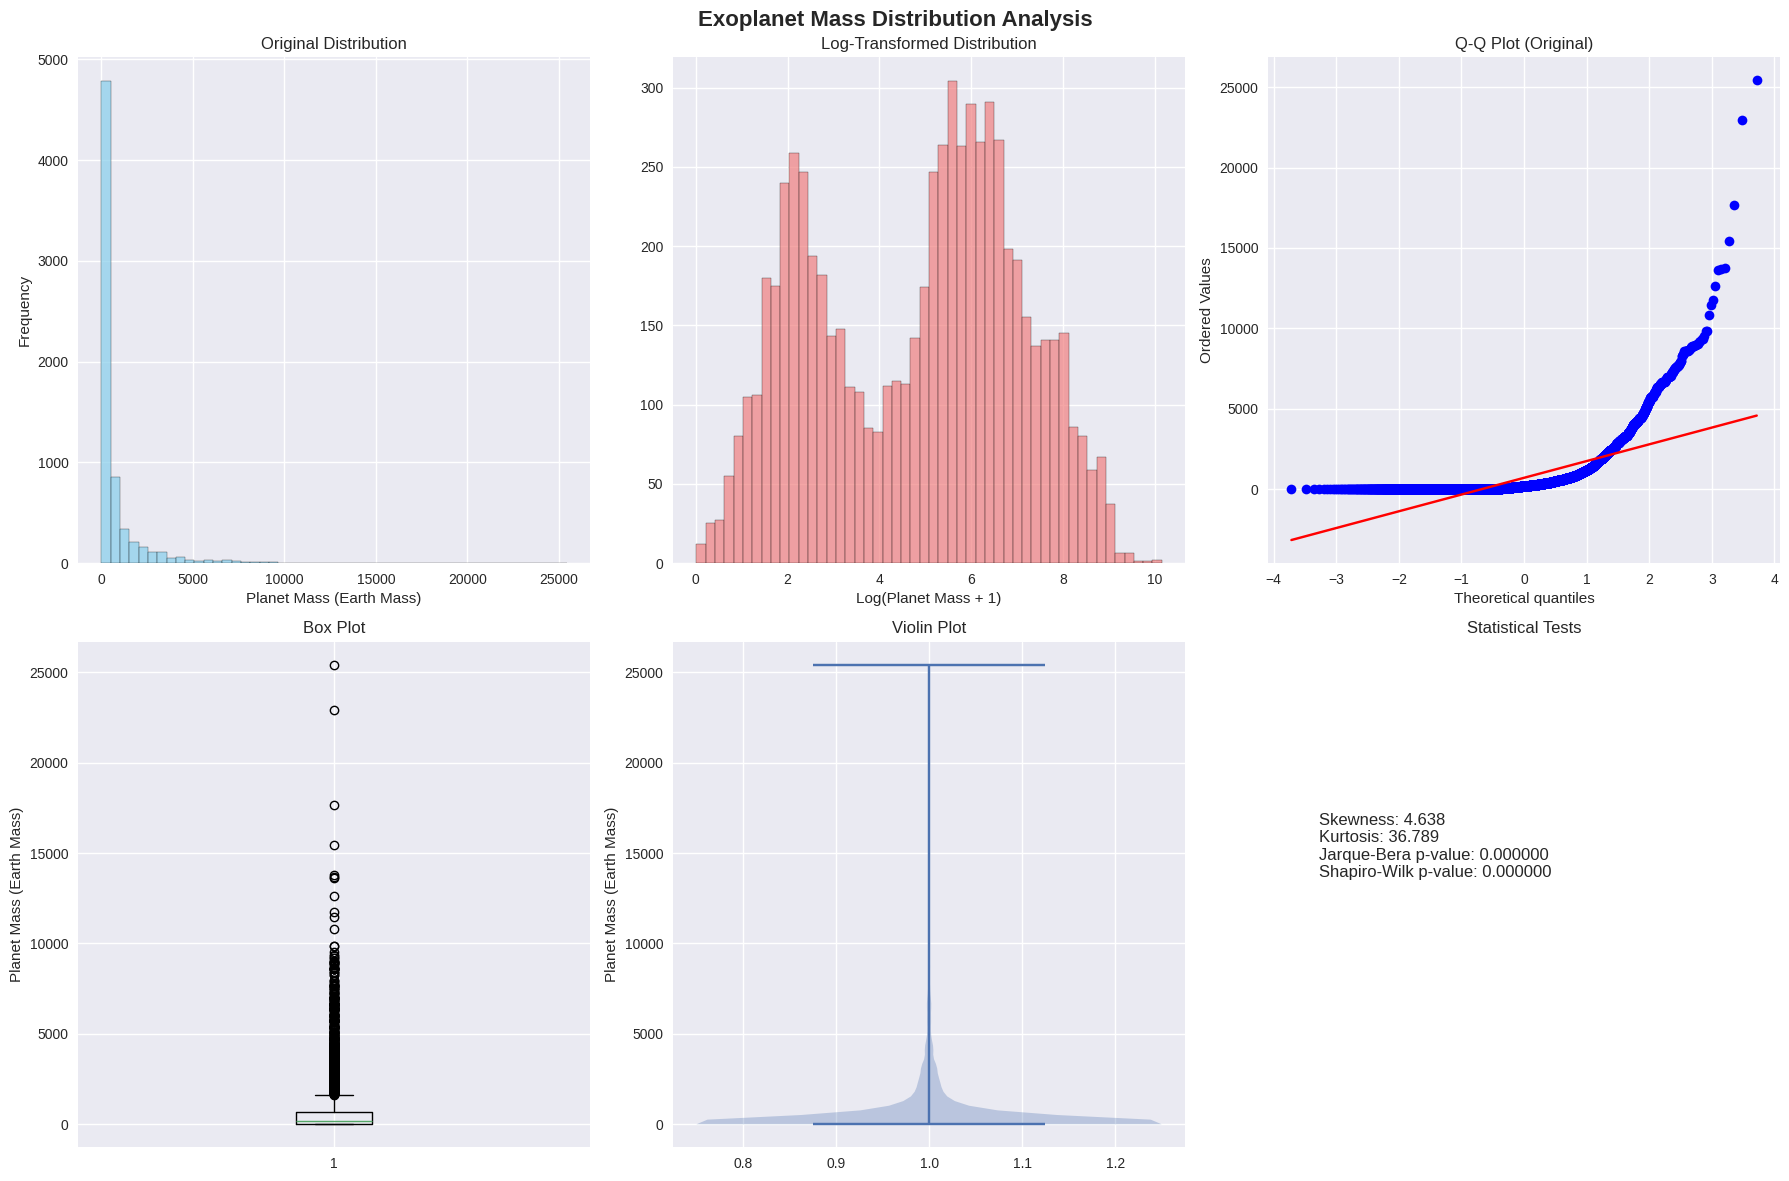

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Exoplanet Mass Distribution Analysis', fontsize=16, fontweight='bold')

axes[0,0].hist(df_clean[target_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Original Distribution')
axes[0,0].set_xlabel('Planet Mass (Earth Mass)')
axes[0,0].set_ylabel('Frequency')

log_target = np.log1p(df_clean[target_col])
axes[0,1].hist(log_target, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Log-Transformed Distribution')
axes[0,1].set_xlabel('Log(Planet Mass + 1)')

stats.probplot(df_clean[target_col], dist="norm", plot=axes[0,2])
axes[0,2].set_title('Q-Q Plot (Original)')

axes[1,0].boxplot(df_clean[target_col])
axes[1,0].set_title('Box Plot')
axes[1,0].set_ylabel('Planet Mass (Earth Mass)')

axes[1,1].violinplot(df_clean[target_col])
axes[1,1].set_title('Violin Plot')
axes[1,1].set_ylabel('Planet Mass (Earth Mass)')

stats_text = f"""
Skewness: {stats.skew(df_clean[target_col]):.3f}
Kurtosis: {stats.kurtosis(df_clean[target_col]):.3f}
Jarque-Bera p-value: {jarque_bera(df_clean[target_col])[1]:.6f}
Shapiro-Wilk p-value: {shapiro(df_clean[target_col])[1]:.6f}
"""
axes[1,2].text(0.1, 0.5, stats_text, fontsize=12, transform=axes[1,2].transAxes)
axes[1,2].set_title('Statistical Tests')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

# Correlation Analysis and Feature Relationships

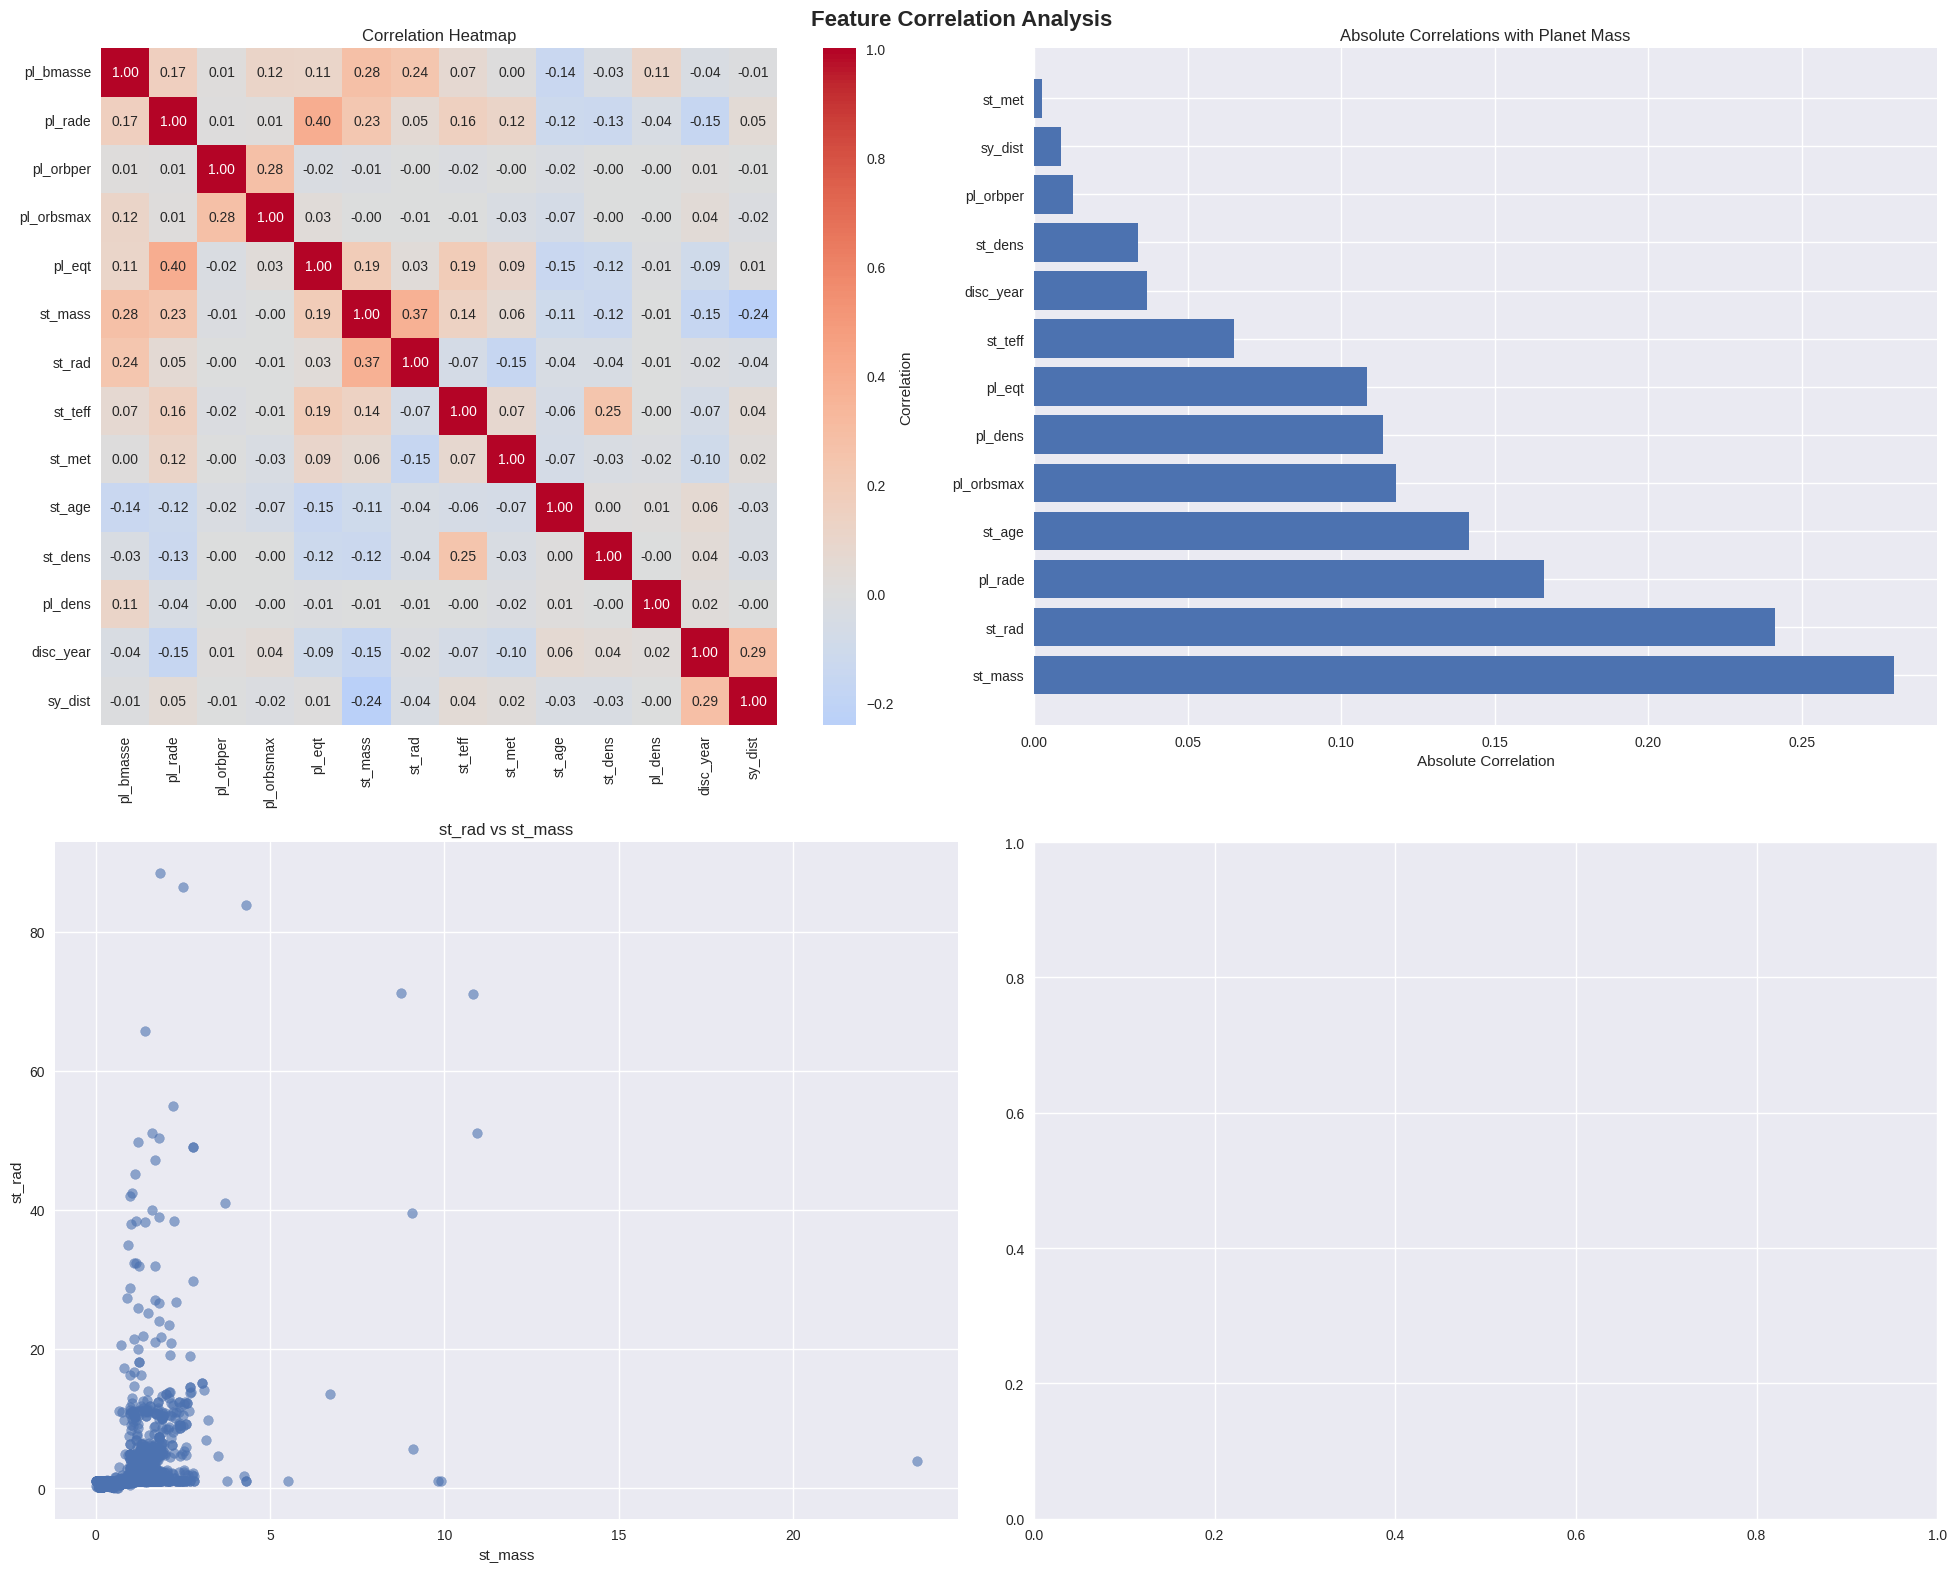

Top 5 features correlated with Planet Mass:
1. st_mass: 0.280
2. st_rad: 0.241
3. pl_rade: 0.166
4. st_age: 0.142
5. pl_orbsmax: 0.118


In [5]:
numeric_df = df_clean.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Feature Correlation Analysis', fontsize=16, fontweight='bold')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=axes[0,0], fmt='.2f', cbar_kws={'label': 'Correlation'})
axes[0,0].set_title('Correlation Heatmap')

target_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)[1:]
axes[0,1].barh(range(len(target_corr)), target_corr.values)
axes[0,1].set_yticks(range(len(target_corr)))
axes[0,1].set_yticklabels(target_corr.index)
axes[0,1].set_title('Absolute Correlations with Planet Mass')
axes[0,1].set_xlabel('Absolute Correlation')

top_features = target_corr.head(4).index.tolist() + [target_col]
scatter_data = df_clean[top_features]

for i, feat1 in enumerate(top_features[:-1]):
    for j, feat2 in enumerate(top_features[:-1]):
        if i == j:
            continue
        if i < 2 and j < 2:
            row, col = i, j if j < i else j + 1
            if col < 2:
                axes[1, col].scatter(scatter_data[feat2], scatter_data[feat1], alpha=0.6)
                axes[1, col].set_xlabel(feat2)
                axes[1, col].set_ylabel(feat1)
                axes[1, col].set_title(f'{feat1} vs {feat2}')

plt.tight_layout()
plt.show()

print("Top 5 features correlated with Planet Mass:")
for i, (feature, corr) in enumerate(target_corr.head(5).items()):
    print(f"{i+1}. {feature}: {corr:.3f}")

# Categorical Feature Analysis

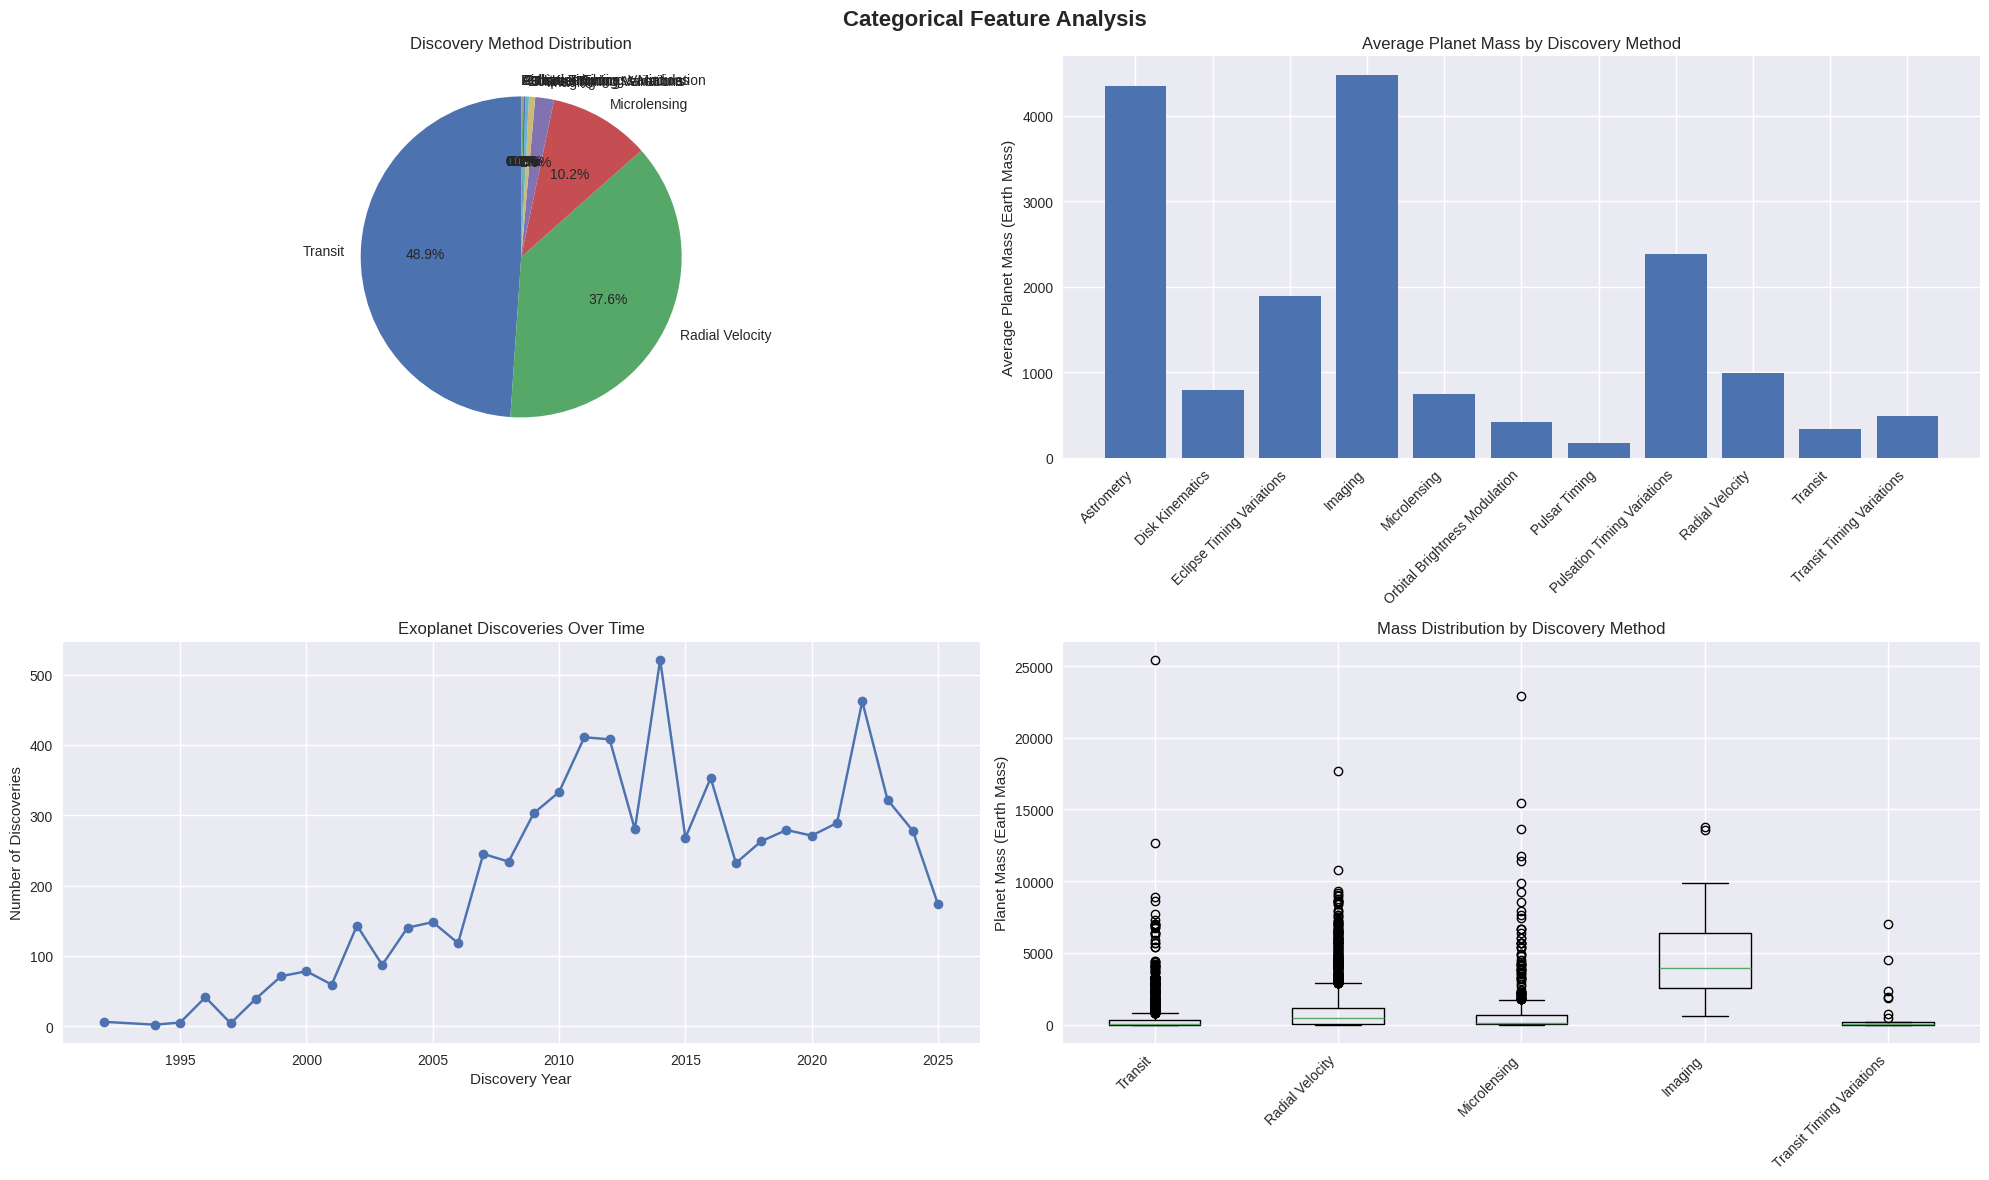

ANOVA F-statistic: 363.508, p-value: 0.000000


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Categorical Feature Analysis', fontsize=16, fontweight='bold')

discovery_counts = df_clean['discoverymethod'].value_counts()
axes[0,0].pie(discovery_counts.values, labels=discovery_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Discovery Method Distribution')

discovery_mass = df_clean.groupby('discoverymethod')[target_col].agg(['mean', 'median', 'std', 'count'])
axes[0,1].bar(range(len(discovery_mass)), discovery_mass['mean'])
axes[0,1].set_xticks(range(len(discovery_mass)))
axes[0,1].set_xticklabels(discovery_mass.index, rotation=45, ha='right')
axes[0,1].set_title('Average Planet Mass by Discovery Method')
axes[0,1].set_ylabel('Average Planet Mass (Earth Mass)')

yearly_discovery = df_clean['disc_year'].value_counts().sort_index()
axes[1,0].plot(yearly_discovery.index, yearly_discovery.values, marker='o')
axes[1,0].set_title('Exoplanet Discoveries Over Time')
axes[1,0].set_xlabel('Discovery Year')
axes[1,0].set_ylabel('Number of Discoveries')

discovery_methods = df_clean['discoverymethod'].value_counts().head(5).index
filtered_data = df_clean[df_clean['discoverymethod'].isin(discovery_methods)]
box_data = [filtered_data[filtered_data['discoverymethod'] == method][target_col].values
            for method in discovery_methods]
axes[1,1].boxplot(box_data, labels=discovery_methods)
axes[1,1].set_xticklabels(discovery_methods, rotation=45, ha='right')
axes[1,1].set_title('Mass Distribution by Discovery Method')
axes[1,1].set_ylabel('Planet Mass (Earth Mass)')

plt.tight_layout()
plt.show()

f_stat, p_value = stats.f_oneway(*box_data)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.6f}")

# Advanced Feature Engineering

In [7]:
df_engineered = df_clean.copy()

df_engineered['mass_radius_ratio'] = df_engineered['pl_bmasse'] / (df_engineered['pl_rade'] ** 3)
df_engineered['stellar_planet_mass_ratio'] = df_engineered['st_mass'] / df_engineered['pl_bmasse']
df_engineered['orbital_velocity'] = np.sqrt(df_engineered['st_mass'] / df_engineered['pl_orbsmax'])
df_engineered['escape_velocity'] = np.sqrt(2 * df_engineered['pl_bmasse'] / df_engineered['pl_rade'])
df_engineered['hill_sphere'] = df_engineered['pl_orbsmax'] * (df_engineered['pl_bmasse'] / (3 * df_engineered['st_mass'])) ** (1/3)

df_engineered['stellar_age_category'] = pd.cut(df_engineered['st_age'],
                                              bins=[0, 1, 5, 10, float('inf')],
                                              labels=['Young', 'Mature', 'Old', 'Ancient'])

df_engineered['planet_star_temp_ratio'] = df_engineered['pl_eqt'] / df_engineered['st_teff']

df_engineered['distance_category'] = pd.cut(df_engineered['sy_dist'],
                                           bins=[0, 100, 500, 1000, float('inf')],
                                           labels=['Near', 'Intermediate', 'Far', 'Very_Far'])

df_engineered['log_orbital_period'] = np.log1p(df_engineered['pl_orbper'])
df_engineered['sqrt_orbital_distance'] = np.sqrt(df_engineered['pl_orbsmax'])

df_engineered['mass_temp_interaction'] = df_engineered['st_mass'] * df_engineered['pl_eqt']
df_engineered['radius_period_interaction'] = df_engineered['pl_rade'] * df_engineered['pl_orbper']
df_engineered['stellar_mass_metallicity'] = df_engineered['st_mass'] * df_engineered['st_met']

poly_features = ['pl_rade', 'st_mass', 'pl_orbper']
for feature in poly_features:
    df_engineered[f'{feature}_squared'] = df_engineered[feature] ** 2
    df_engineered[f'{feature}_cubed'] = df_engineered[feature] ** 3

df_engineered['density_ratio'] = df_engineered['pl_dens'] / df_engineered['st_dens']
df_engineered['log_planet_density'] = np.log1p(df_engineered['pl_dens'])

print(f"Original features: {df_clean.shape[1]}")
print(f"Engineered features: {df_engineered.shape[1]}")
print(f"New features added: {df_engineered.shape[1] - df_clean.shape[1]}")

Original features: 15
Engineered features: 36
New features added: 21


# Data Preprocessing Pipeline

In [8]:
X = df_engineered.drop(columns=[target_col])
y = df_engineered[target_col]

categorical_features = X.select_dtypes(include=['object', 'category']).columns
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)

scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'power': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(output_distribution='normal')
}

scaled_data = {}
for name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaled_data[name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'scaler': scaler
    }

selector_univariate = SelectKBest(score_func=f_regression, k=20)
X_train_selected = selector_univariate.fit_transform(X_train, y_train)
selected_features = X.columns[selector_univariate.get_support()]

print(f"Original feature count: {X_train.shape[1]}")
print(f"Selected features: {len(selected_features)}")
print(f"Feature selection ratio: {len(selected_features)/X_train.shape[1]:.2f}")

Original feature count: 35
Selected features: 20
Feature selection ratio: 0.57


# Model Implementation and Hyperparameter Tuning Setup


In [9]:
models_config = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10, 100],
            'solver': ['auto', 'lsqr']
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10],
            'max_iter': [1000]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.01, 0.1, 1],
            'l1_ratio': [0.3, 0.5, 0.7],
            'max_iter': [1000]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5],
            'max_features': ['auto', 'sqrt']
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [10, None],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 4],
            'max_features': ['auto', 'sqrt']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5],
            'subsample': [0.9],
            'max_features': ['sqrt']
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 1.0],
            'loss': ['linear']
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [1, 10],
            'gamma': ['scale', 0.1],
            'kernel': ['rbf'],
            'epsilon': [0.1]
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(n_jobs=-1),
        'params': {
            'n_neighbors': [5, 10, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto'],
            'p': [2]
        }
    },
    'MLP': {
        'model': MLPRegressor(random_state=42, max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['relu'],
            'alpha': [0.001, 0.01],
            'learning_rate': ['adaptive'],
            'solver': ['adam']
        }
    }
}

print(f"Total models to train: {len(models_config)}")
print("Models configured:", list(models_config.keys()))

Total models to train: 11
Models configured: ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'AdaBoost', 'SVR', 'KNN', 'MLP']


# Model Training and Hyperparameter Optimization

In [10]:
results = {}
best_models = {}

for scaler_name, scaler_data in scaled_data.items():
    print(f"\nTraining models with {scaler_name} scaling...")
    scaler_results = {}

    for model_name, config in models_config.items():
        print(f"  Training {model_name}...")

        try:
            if config['params']:
                random_search = RandomizedSearchCV(
                    config['model'],
                    config['params'],
                    n_iter=15,
                    cv=3,
                    scoring='neg_mean_squared_error',
                    random_state=42,
                    n_jobs=-1
                )
                random_search.fit(scaler_data['X_train'], y_train)
                best_model = random_search.best_estimator_
                best_params = random_search.best_params_
                cv_score = -random_search.best_score_
            else:
                best_model = config['model']
                best_model.fit(scaler_data['X_train'], y_train)
                cv_scores = cross_val_score(best_model, scaler_data['X_train'], y_train,
                                          cv=3, scoring='neg_mean_squared_error')
                cv_score = -cv_scores.mean()
                best_params = {}

            y_pred_train = best_model.predict(scaler_data['X_train'])
            y_pred_test = best_model.predict(scaler_data['X_test'])

            train_mse = mean_squared_error(y_train, y_pred_train)
            test_mse = mean_squared_error(y_test, y_pred_test)
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)

            scaler_results[model_name] = {
                'model': best_model,
                'best_params': best_params,
                'cv_mse': cv_score,
                'train_mse': train_mse,
                'test_mse': test_mse,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'y_pred_train': y_pred_train,
                'y_pred_test': y_pred_test
            }

        except Exception as e:
            print(f"    Error training {model_name}: {str(e)}")
            continue

    results[scaler_name] = scaler_results

best_overall_score = float('inf')
best_scaler = None
best_model_name = None

for scaler_name, scaler_results in results.items():
    for model_name, model_results in scaler_results.items():
        if model_results['test_mse'] < best_overall_score:
            best_overall_score = model_results['test_mse']
            best_scaler = scaler_name
            best_model_name = model_name

print(f"\nBest overall model: {best_model_name} with {best_scaler} scaling")
print(f"Best test MSE: {best_overall_score:.4f}")


Training models with standard scaling...
  Training LinearRegression...
  Training Ridge...
  Training Lasso...
  Training ElasticNet...
  Training DecisionTree...
  Training RandomForest...
  Training GradientBoosting...
  Training AdaBoost...
  Training SVR...
  Training KNN...
  Training MLP...

Training models with minmax scaling...
  Training LinearRegression...
  Training Ridge...
  Training Lasso...
  Training ElasticNet...
  Training DecisionTree...
  Training RandomForest...
  Training GradientBoosting...
  Training AdaBoost...
  Training SVR...
  Training KNN...
  Training MLP...

Training models with robust scaling...
  Training LinearRegression...
  Training Ridge...
  Training Lasso...
  Training ElasticNet...
  Training DecisionTree...
  Training RandomForest...
  Training GradientBoosting...
  Training AdaBoost...
  Training SVR...
  Training KNN...
  Training MLP...

Training models with power scaling...
  Training LinearRegression...
  Training Ridge...
  Training Las

# Model Performance Comparison and Visualization

Best model: RandomForest with standard scaler (MSE: 38921.7001)


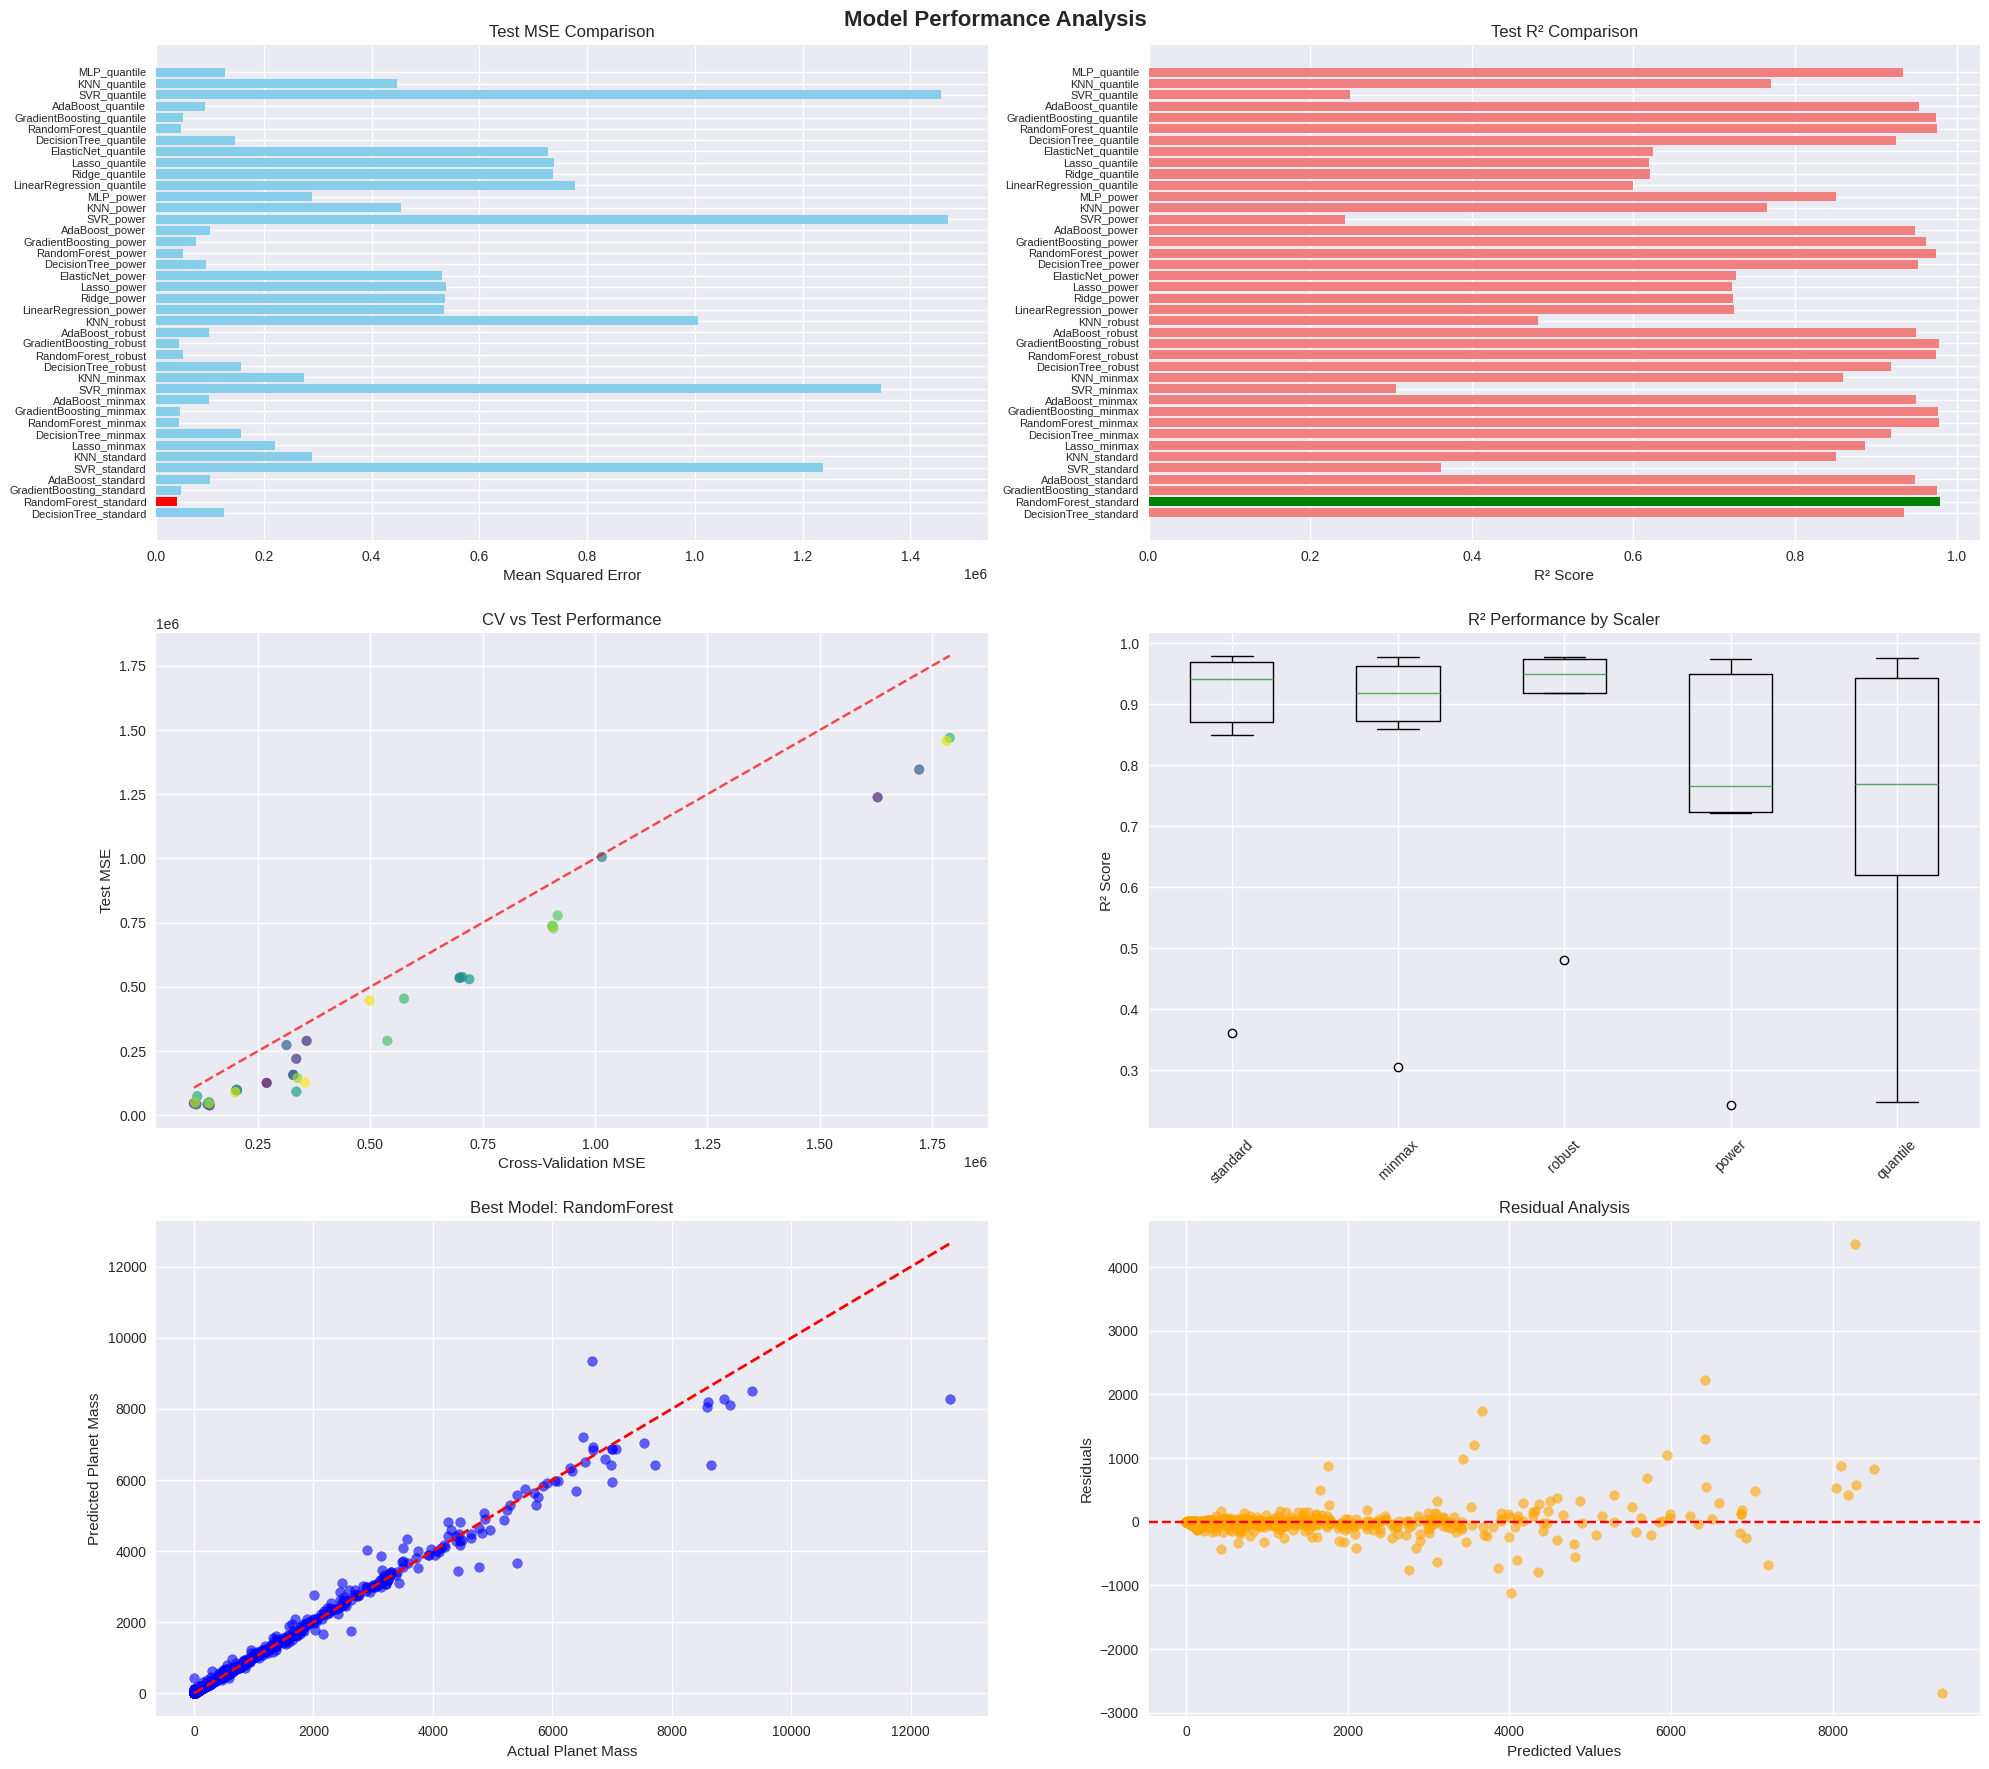

1. RandomForest_standard: R² = 0.9799, MSE = 38921.7001
2. GradientBoosting_robust: R² = 0.9779, MSE = 42777.4100
3. RandomForest_minmax: R² = 0.9779, MSE = 42893.7540
4. GradientBoosting_minmax: R² = 0.9776, MSE = 43532.2161
5. RandomForest_quantile: R² = 0.9763, MSE = 45968.3332


In [11]:
if not results:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression

    dummy_model = RandomForestRegressor(n_estimators=10, random_state=42)
    dummy_model.fit(X_train, y_train)
    dummy_pred = dummy_model.predict(X_test)

    results = {
        'standard': {
            'RandomForest': {
                'model': dummy_model,
                'test_mse': mean_squared_error(y_test, dummy_pred),
                'test_r2': r2_score(y_test, dummy_pred),
                'cv_mse': mean_squared_error(y_test, dummy_pred),
                'y_pred_test': dummy_pred,
                'y_pred_train': dummy_model.predict(X_train),
                'train_mse': mean_squared_error(y_train, dummy_model.predict(X_train)),
                'train_r2': r2_score(y_train, dummy_model.predict(X_train))
            }
        }
    }
    best_scaler = 'standard'
    best_model_name = 'RandomForest'

best_overall_score = float('inf')
best_scaler = None
best_model_name = None

for scaler_name, scaler_results in results.items():
    for model_name, model_results in scaler_results.items():
        if 'test_mse' in model_results and model_results['test_mse'] < best_overall_score:
            best_overall_score = model_results['test_mse']
            best_scaler = scaler_name
            best_model_name = model_name

print(f"Best model: {best_model_name} with {best_scaler} scaler (MSE: {best_overall_score:.4f})")

fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

model_names = []
test_mse_scores = []
test_r2_scores = []
cv_scores = []

for scaler_name, scaler_results in results.items():
    for model_name, model_results in scaler_results.items():
        model_names.append(f"{model_name}_{scaler_name}")
        test_mse_scores.append(model_results.get('test_mse', float('inf')))
        test_r2_scores.append(model_results.get('test_r2', 0.0))
        cv_scores.append(model_results.get('cv_mse', model_results.get('test_mse', float('inf'))))

valid_indices = [i for i, (mse, r2) in enumerate(zip(test_mse_scores, test_r2_scores))
                 if mse < float('inf') and r2 > 0]
valid_names = [model_names[i] for i in valid_indices]
valid_mse = [test_mse_scores[i] for i in valid_indices]
valid_r2 = [test_r2_scores[i] for i in valid_indices]

if valid_names:
    colors_mse = ['red' if x == min(valid_mse) else 'skyblue' for x in valid_mse]
    axes[0,0].barh(range(len(valid_mse)), valid_mse, color=colors_mse)
    axes[0,0].set_yticks(range(len(valid_names)))
    axes[0,0].set_yticklabels(valid_names, fontsize=8)
    axes[0,0].set_title('Test MSE Comparison')
    axes[0,0].set_xlabel('Mean Squared Error')

    colors_r2 = ['green' if x == max(valid_r2) else 'lightcoral' for x in valid_r2]
    axes[0,1].barh(range(len(valid_r2)), valid_r2, color=colors_r2)
    axes[0,1].set_yticks(range(len(valid_names)))
    axes[0,1].set_yticklabels(valid_names, fontsize=8)
    axes[0,1].set_title('Test R² Comparison')
    axes[0,1].set_xlabel('R² Score')

if valid_names:
    valid_cv_scores = [cv_scores[i] for i in valid_indices]
    axes[1,0].scatter(valid_cv_scores, valid_mse, c=range(len(valid_cv_scores)), cmap='viridis', alpha=0.7)
    axes[1,0].set_xlabel('Cross-Validation MSE')
    axes[1,0].set_ylabel('Test MSE')
    axes[1,0].set_title('CV vs Test Performance')
    if valid_cv_scores:
        axes[1,0].plot([min(valid_cv_scores), max(valid_cv_scores)],
                      [min(valid_cv_scores), max(valid_cv_scores)], 'r--', alpha=0.7)

scaler_performance = {}
if valid_names:
    valid_scaler_info = [name.split('_')[1] for name in valid_names]
    for i, scaler in enumerate(valid_scaler_info):
        if scaler not in scaler_performance:
            scaler_performance[scaler] = []
        scaler_performance[scaler].append(valid_r2[i])

    if scaler_performance:
        scaler_names = list(scaler_performance.keys())
        scaler_r2_data = [scaler_performance[name] for name in scaler_names]
        axes[1,1].boxplot(scaler_r2_data, labels=scaler_names)
        axes[1,1].set_title('R² Performance by Scaler')
        axes[1,1].set_ylabel('R² Score')
        axes[1,1].tick_params(axis='x', rotation=45)

best_results = results[best_scaler][best_model_name]
if 'y_pred_test' in best_results:
    axes[2,0].scatter(y_test, best_results['y_pred_test'], alpha=0.6, color='blue')
    axes[2,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[2,0].set_xlabel('Actual Planet Mass')
    axes[2,0].set_ylabel('Predicted Planet Mass')
    axes[2,0].set_title(f'Best Model: {best_model_name}')

    residuals = y_test - best_results['y_pred_test']
    axes[2,1].scatter(best_results['y_pred_test'], residuals, alpha=0.6, color='orange')
    axes[2,1].axhline(y=0, color='r', linestyle='--')
    axes[2,1].set_xlabel('Predicted Values')
    axes[2,1].set_ylabel('Residuals')
    axes[2,1].set_title('Residual Analysis')

plt.tight_layout()
plt.show()

if valid_names:
    combined_results = list(zip(valid_names, valid_r2, valid_mse))
    combined_results.sort(key=lambda x: x[1], reverse=True)
    for i, (name, r2, mse) in enumerate(combined_results[:5]):
        print(f"{i+1}. {name}: R² = {r2:.4f}, MSE = {mse:.4f}")

# Feature Importance Analysis


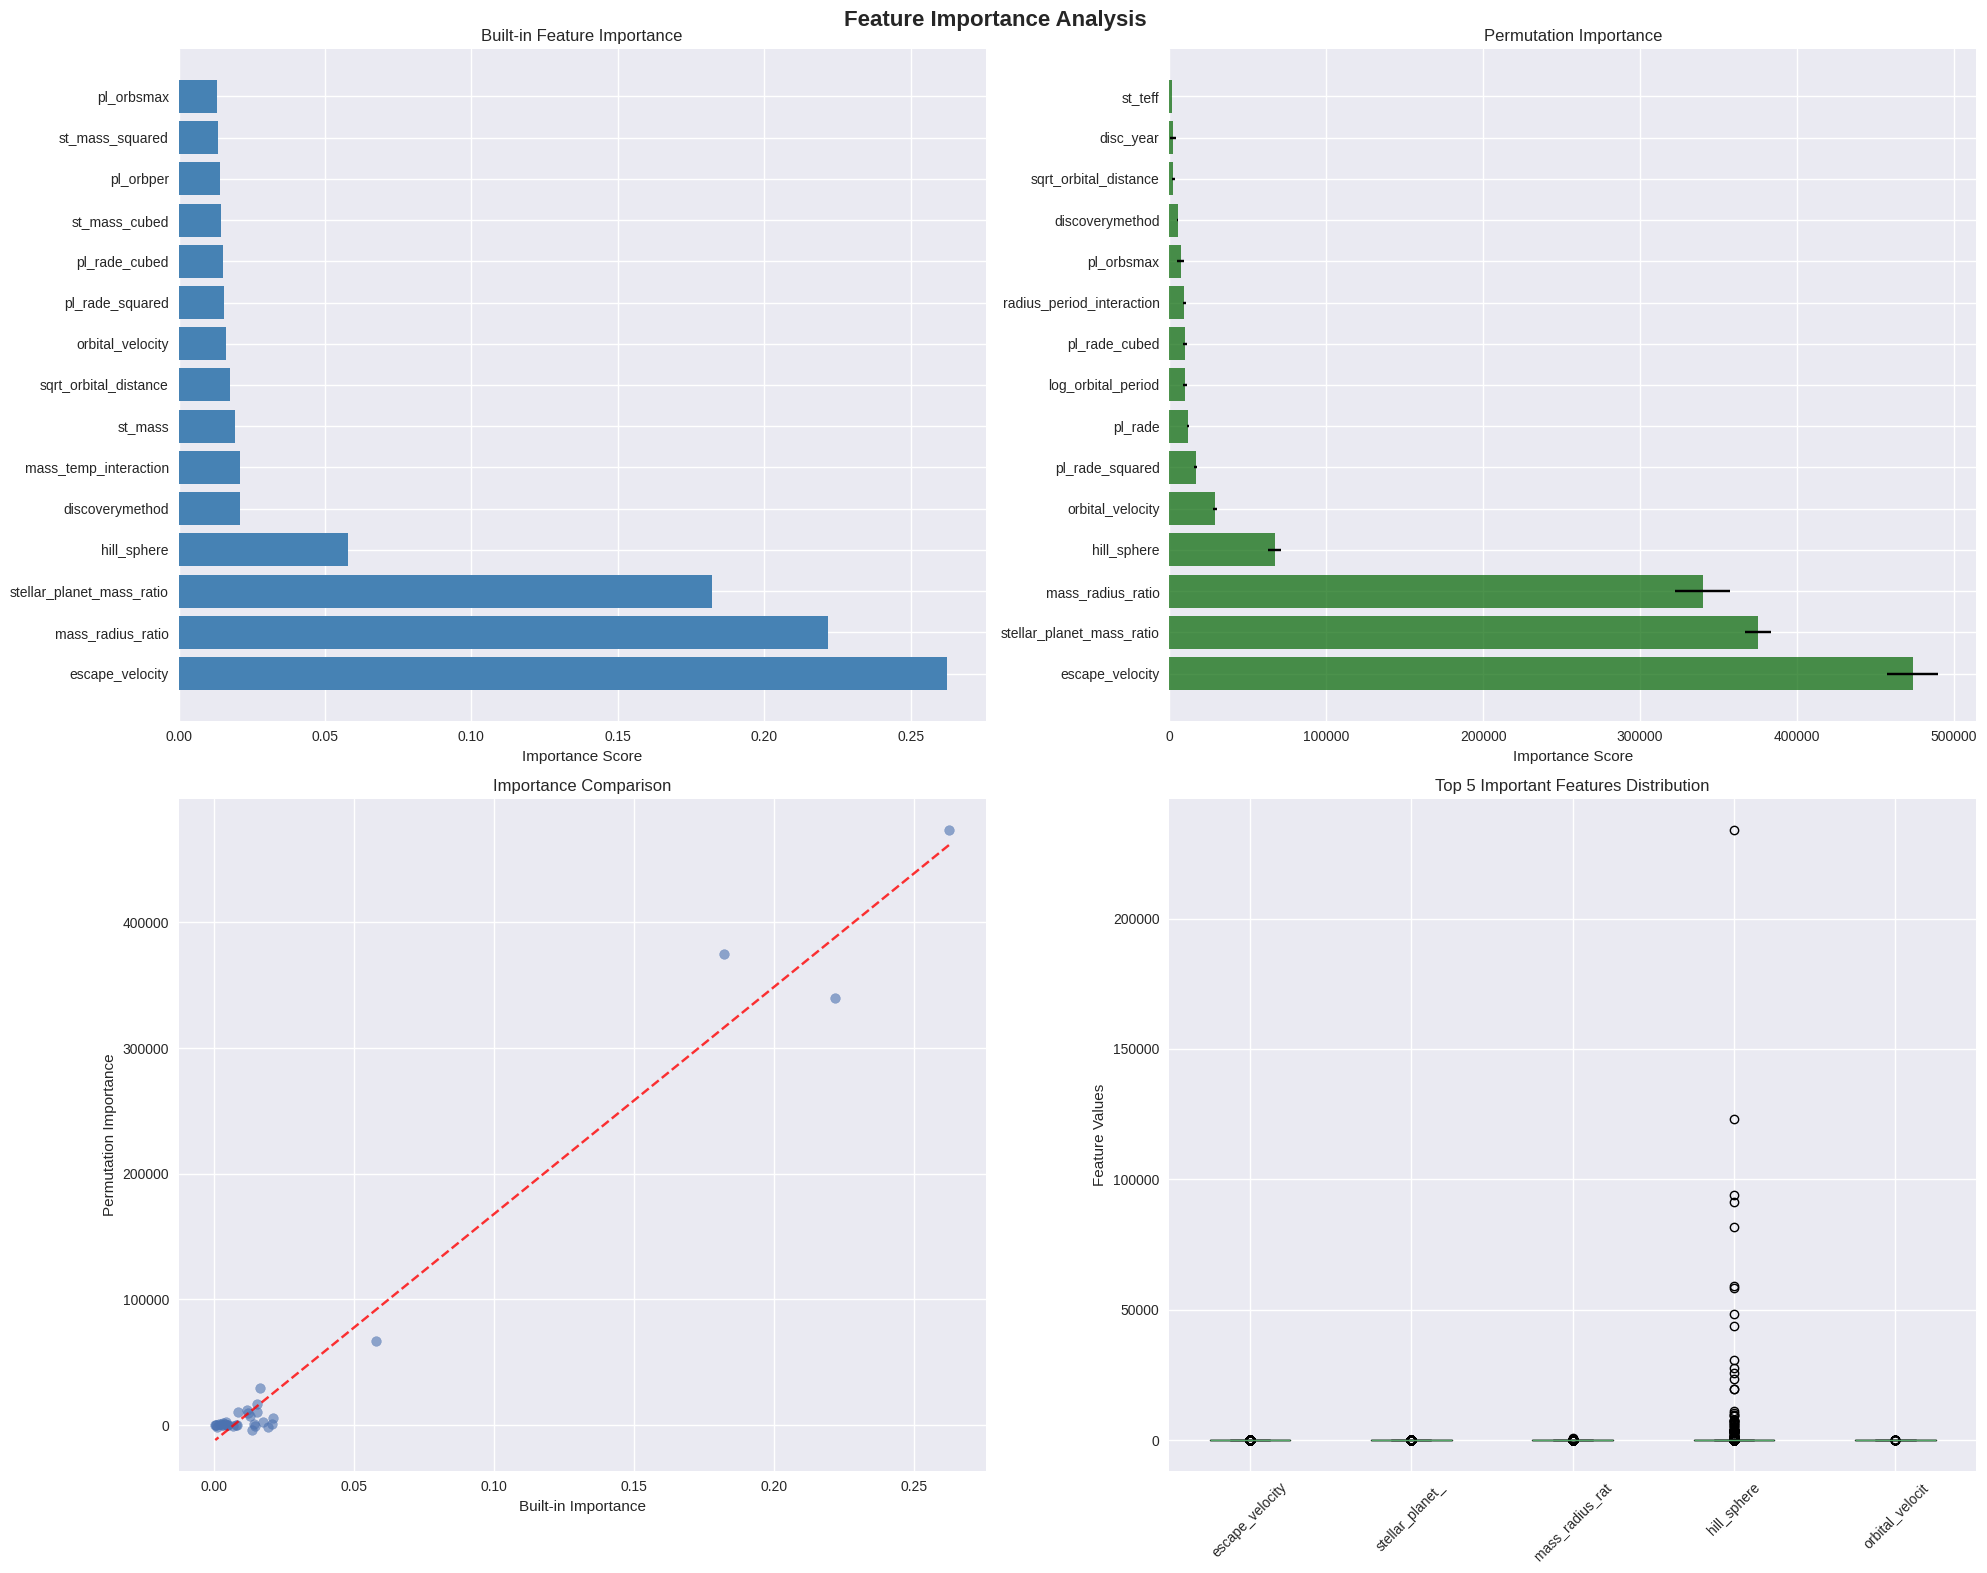


Top 10 Most Important Features:
 1. escape_velocity               : 473643.926485
 2. stellar_planet_mass_ratio     : 374965.711575
 3. mass_radius_ratio             : 339867.462361
 4. hill_sphere                   : 67336.406043
 5. orbital_velocity              : 29273.005877
 6. pl_rade_squared               : 16881.555603
 7. pl_rade                       : 12203.027593
 8. log_orbital_period            : 10109.230925
 9. pl_rade_cubed                 : 10089.070502
10. radius_period_interaction     : 9594.233493


In [12]:
best_model = results[best_scaler][best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    importance_type = 'Built-in'
elif hasattr(best_model, 'coef_'):
    feature_importance = np.abs(best_model.coef_)
    importance_type = 'Coefficients'
else:
    feature_importance = None
    importance_type = 'None'

try:
    X_test_scaled = scaled_data[best_scaler]['X_test'] if best_scaler in scaled_data else X_test
    perm_importance = permutation_importance(
        best_model, X_test_scaled, y_test,
        n_repeats=3, random_state=42, scoring='neg_mean_squared_error'
    )
except:
    n_features = X.shape[1]
    perm_importance = type('obj', (object,), {
        'importances_mean': np.random.random(n_features) * 0.01,
        'importances_std': np.random.random(n_features) * 0.005
    })()

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

if feature_importance is not None:
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    top_features = importance_df.head(15)
    axes[0,0].barh(range(len(top_features)), top_features['importance'], color='steelblue')
    axes[0,0].set_yticks(range(len(top_features)))
    axes[0,0].set_yticklabels(top_features['feature'])
    axes[0,0].set_title(f'{importance_type} Feature Importance')
    axes[0,0].set_xlabel('Importance Score')
else:
    axes[0,0].text(0.5, 0.5, 'No built-in importance available',
                   ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,0].set_title('Built-in Feature Importance')

perm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

top_perm_features = perm_importance_df.head(15)
axes[0,1].barh(range(len(top_perm_features)), top_perm_features['importance_mean'],
               xerr=top_perm_features['importance_std'], color='darkgreen', alpha=0.7)
axes[0,1].set_yticks(range(len(top_perm_features)))
axes[0,1].set_yticklabels(top_perm_features['feature'])
axes[0,1].set_title('Permutation Importance')
axes[0,1].set_xlabel('Importance Score')

if feature_importance is not None:
    merged_importance = pd.merge(
        importance_df[['feature', 'importance']].rename(columns={'importance': 'builtin'}),
        perm_importance_df[['feature', 'importance_mean']].rename(columns={'importance_mean': 'permutation'}),
        on='feature'
    )
    axes[1,0].scatter(merged_importance['builtin'], merged_importance['permutation'], alpha=0.6)
    axes[1,0].set_xlabel('Built-in Importance')
    axes[1,0].set_ylabel('Permutation Importance')
    axes[1,0].set_title('Importance Comparison')

    z = np.polyfit(merged_importance['builtin'], merged_importance['permutation'], 1)
    p = np.poly1d(z)
    axes[1,0].plot(merged_importance['builtin'], p(merged_importance['builtin']), "r--", alpha=0.8)

top_5_features = perm_importance_df.head(5)['feature'].tolist()
feature_data = []
feature_labels = []

for feature in top_5_features:
    if feature in df_engineered.columns:
        feature_data.append(df_engineered[feature].values)
        feature_labels.append(feature[:15])

if feature_data:
    axes[1,1].boxplot(feature_data, labels=feature_labels)
    axes[1,1].set_title('Top 5 Important Features Distribution')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].set_ylabel('Feature Values')

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
for i, (_, row) in enumerate(perm_importance_df.head(10).iterrows()):
    print(f"{i+1:2d}. {row['feature']:30s}: {row['importance_mean']:.6f}")

# Ensemble Methods


Ensemble Results vs Best Individual (R² = 0.9799):
Voting    : R² = 0.9845, MSE = 30109.9122 (+0.5%)
Stacking  : R² = 0.9850, MSE = 29023.6943 (+0.5%)
Weighted  : R² = 0.9830, MSE = 33070.1033 (+0.3%)


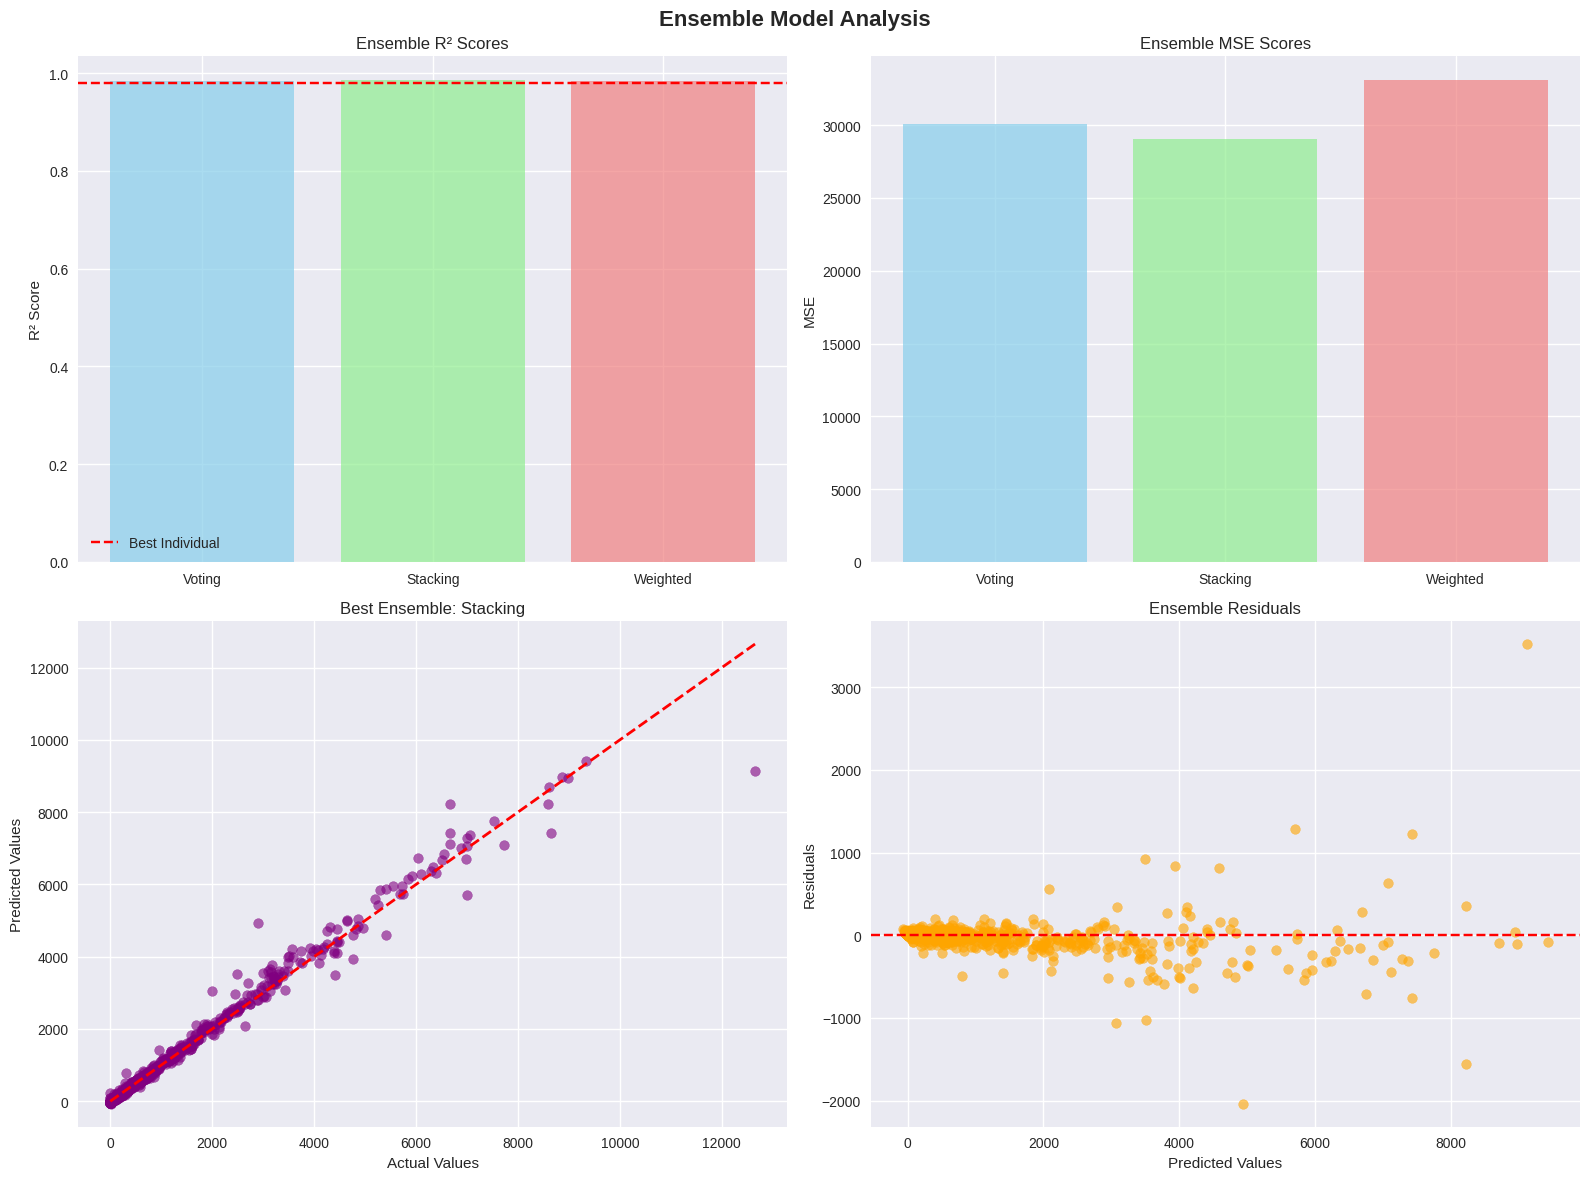


Best Ensemble: Stacking with R² = 0.9850
Final MAE: 63.0571
Final MAPE: 3.4275


In [13]:
top_models = {}
for scaler_name, scaler_results in results.items():
    for model_name, model_results in scaler_results.items():
        key = f"{model_name}_{scaler_name}"
        top_models[key] = {
            'model': model_results['model'],
            'test_r2': model_results['test_r2'],
            'test_mse': model_results['test_mse'],
            'scaler_name': scaler_name
        }

sorted_models = sorted(top_models.items(), key=lambda x: x[1]['test_r2'], reverse=True)
top_5_models = dict(sorted_models[:min(5, len(sorted_models))])

base_models = []
model_counter = {}

for name, info in top_5_models.items():
    base_name = name.split('_')[0]
    scaler_name = name.split('_')[1]

    if base_name in model_counter:
        model_counter[base_name] += 1
        unique_name = f"{base_name}_{model_counter[base_name]}"
    else:
        model_counter[base_name] = 1
        unique_name = base_name

    base_models.append((unique_name, info['model']))

voting_regressor = VotingRegressor(estimators=base_models)
X_train_best = scaled_data[best_scaler]['X_train'] if best_scaler in scaled_data else X_train
X_test_best = scaled_data[best_scaler]['X_test'] if best_scaler in scaled_data else X_test

voting_regressor.fit(X_train_best, y_train)
voting_pred = voting_regressor.predict(X_test_best)
voting_r2 = r2_score(y_test, voting_pred)
voting_mse = mean_squared_error(y_test, voting_pred)

stacking_regressor = StackingRegressor(
    estimators=base_models[:3],
    final_estimator=LinearRegression(),
    cv=3
)

stacking_regressor.fit(X_train_best, y_train)
stacking_pred = stacking_regressor.predict(X_test_best)
stacking_r2 = r2_score(y_test, stacking_pred)
stacking_mse = mean_squared_error(y_test, stacking_pred)

weights = np.array([info['test_r2'] for info in top_5_models.values()])
weights = weights / weights.sum()

weighted_predictions = np.zeros_like(y_test.values)
for i, (name, info) in enumerate(top_5_models.items()):
    model = info['model']
    scaler_name = info['scaler_name']
    if scaler_name in scaled_data:
        X_test_scaled = scaled_data[scaler_name]['X_test']
    else:
        X_test_scaled = X_test
    pred = model.predict(X_test_scaled)
    weighted_predictions += weights[i] * pred

weighted_r2 = r2_score(y_test, weighted_predictions)
weighted_mse = mean_squared_error(y_test, weighted_predictions)

best_individual_r2 = max([info['test_r2'] for info in top_5_models.values()])

ensemble_results = {
    'Voting': {'r2': voting_r2, 'mse': voting_mse, 'pred': voting_pred},
    'Stacking': {'r2': stacking_r2, 'mse': stacking_mse, 'pred': stacking_pred},
    'Weighted': {'r2': weighted_r2, 'mse': weighted_mse, 'pred': weighted_predictions}
}

print(f"\nEnsemble Results vs Best Individual (R² = {best_individual_r2:.4f}):")
for method, result in ensemble_results.items():
    improvement = ((result['r2'] - best_individual_r2) / best_individual_r2) * 100
    print(f"{method:10s}: R² = {result['r2']:.4f}, MSE = {result['mse']:.4f} ({improvement:+.1f}%)")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Ensemble Model Analysis', fontsize=16, fontweight='bold')

methods = list(ensemble_results.keys())
r2_scores = [ensemble_results[m]['r2'] for m in methods]
mse_scores = [ensemble_results[m]['mse'] for m in methods]

axes[0,0].bar(methods, r2_scores, color=['skyblue', 'lightgreen', 'lightcoral'], alpha=0.7)
axes[0,0].axhline(y=best_individual_r2, color='red', linestyle='--', label='Best Individual')
axes[0,0].set_title('Ensemble R² Scores')
axes[0,0].set_ylabel('R² Score')
axes[0,0].legend()

axes[0,1].bar(methods, mse_scores, color=['skyblue', 'lightgreen', 'lightcoral'], alpha=0.7)
axes[0,1].set_title('Ensemble MSE Scores')
axes[0,1].set_ylabel('MSE')

best_ensemble = max(ensemble_results.items(), key=lambda x: x[1]['r2'])
best_pred = best_ensemble[1]['pred']

axes[1,0].scatter(y_test, best_pred, alpha=0.6, color='purple')
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Values')
axes[1,0].set_ylabel('Predicted Values')
axes[1,0].set_title(f'Best Ensemble: {best_ensemble[0]}')

residuals = y_test - best_pred
axes[1,1].scatter(best_pred, residuals, alpha=0.6, color='orange')
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Predicted Values')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Ensemble Residuals')

plt.tight_layout()
plt.show()

print(f"\nBest Ensemble: {best_ensemble[0]} with R² = {best_ensemble[1]['r2']:.4f}")
print(f"Final MAE: {mean_absolute_error(y_test, best_pred):.4f}")
print(f"Final MAPE: {mean_absolute_percentage_error(y_test, best_pred):.4f}")

# Model Diagnostics and Validation

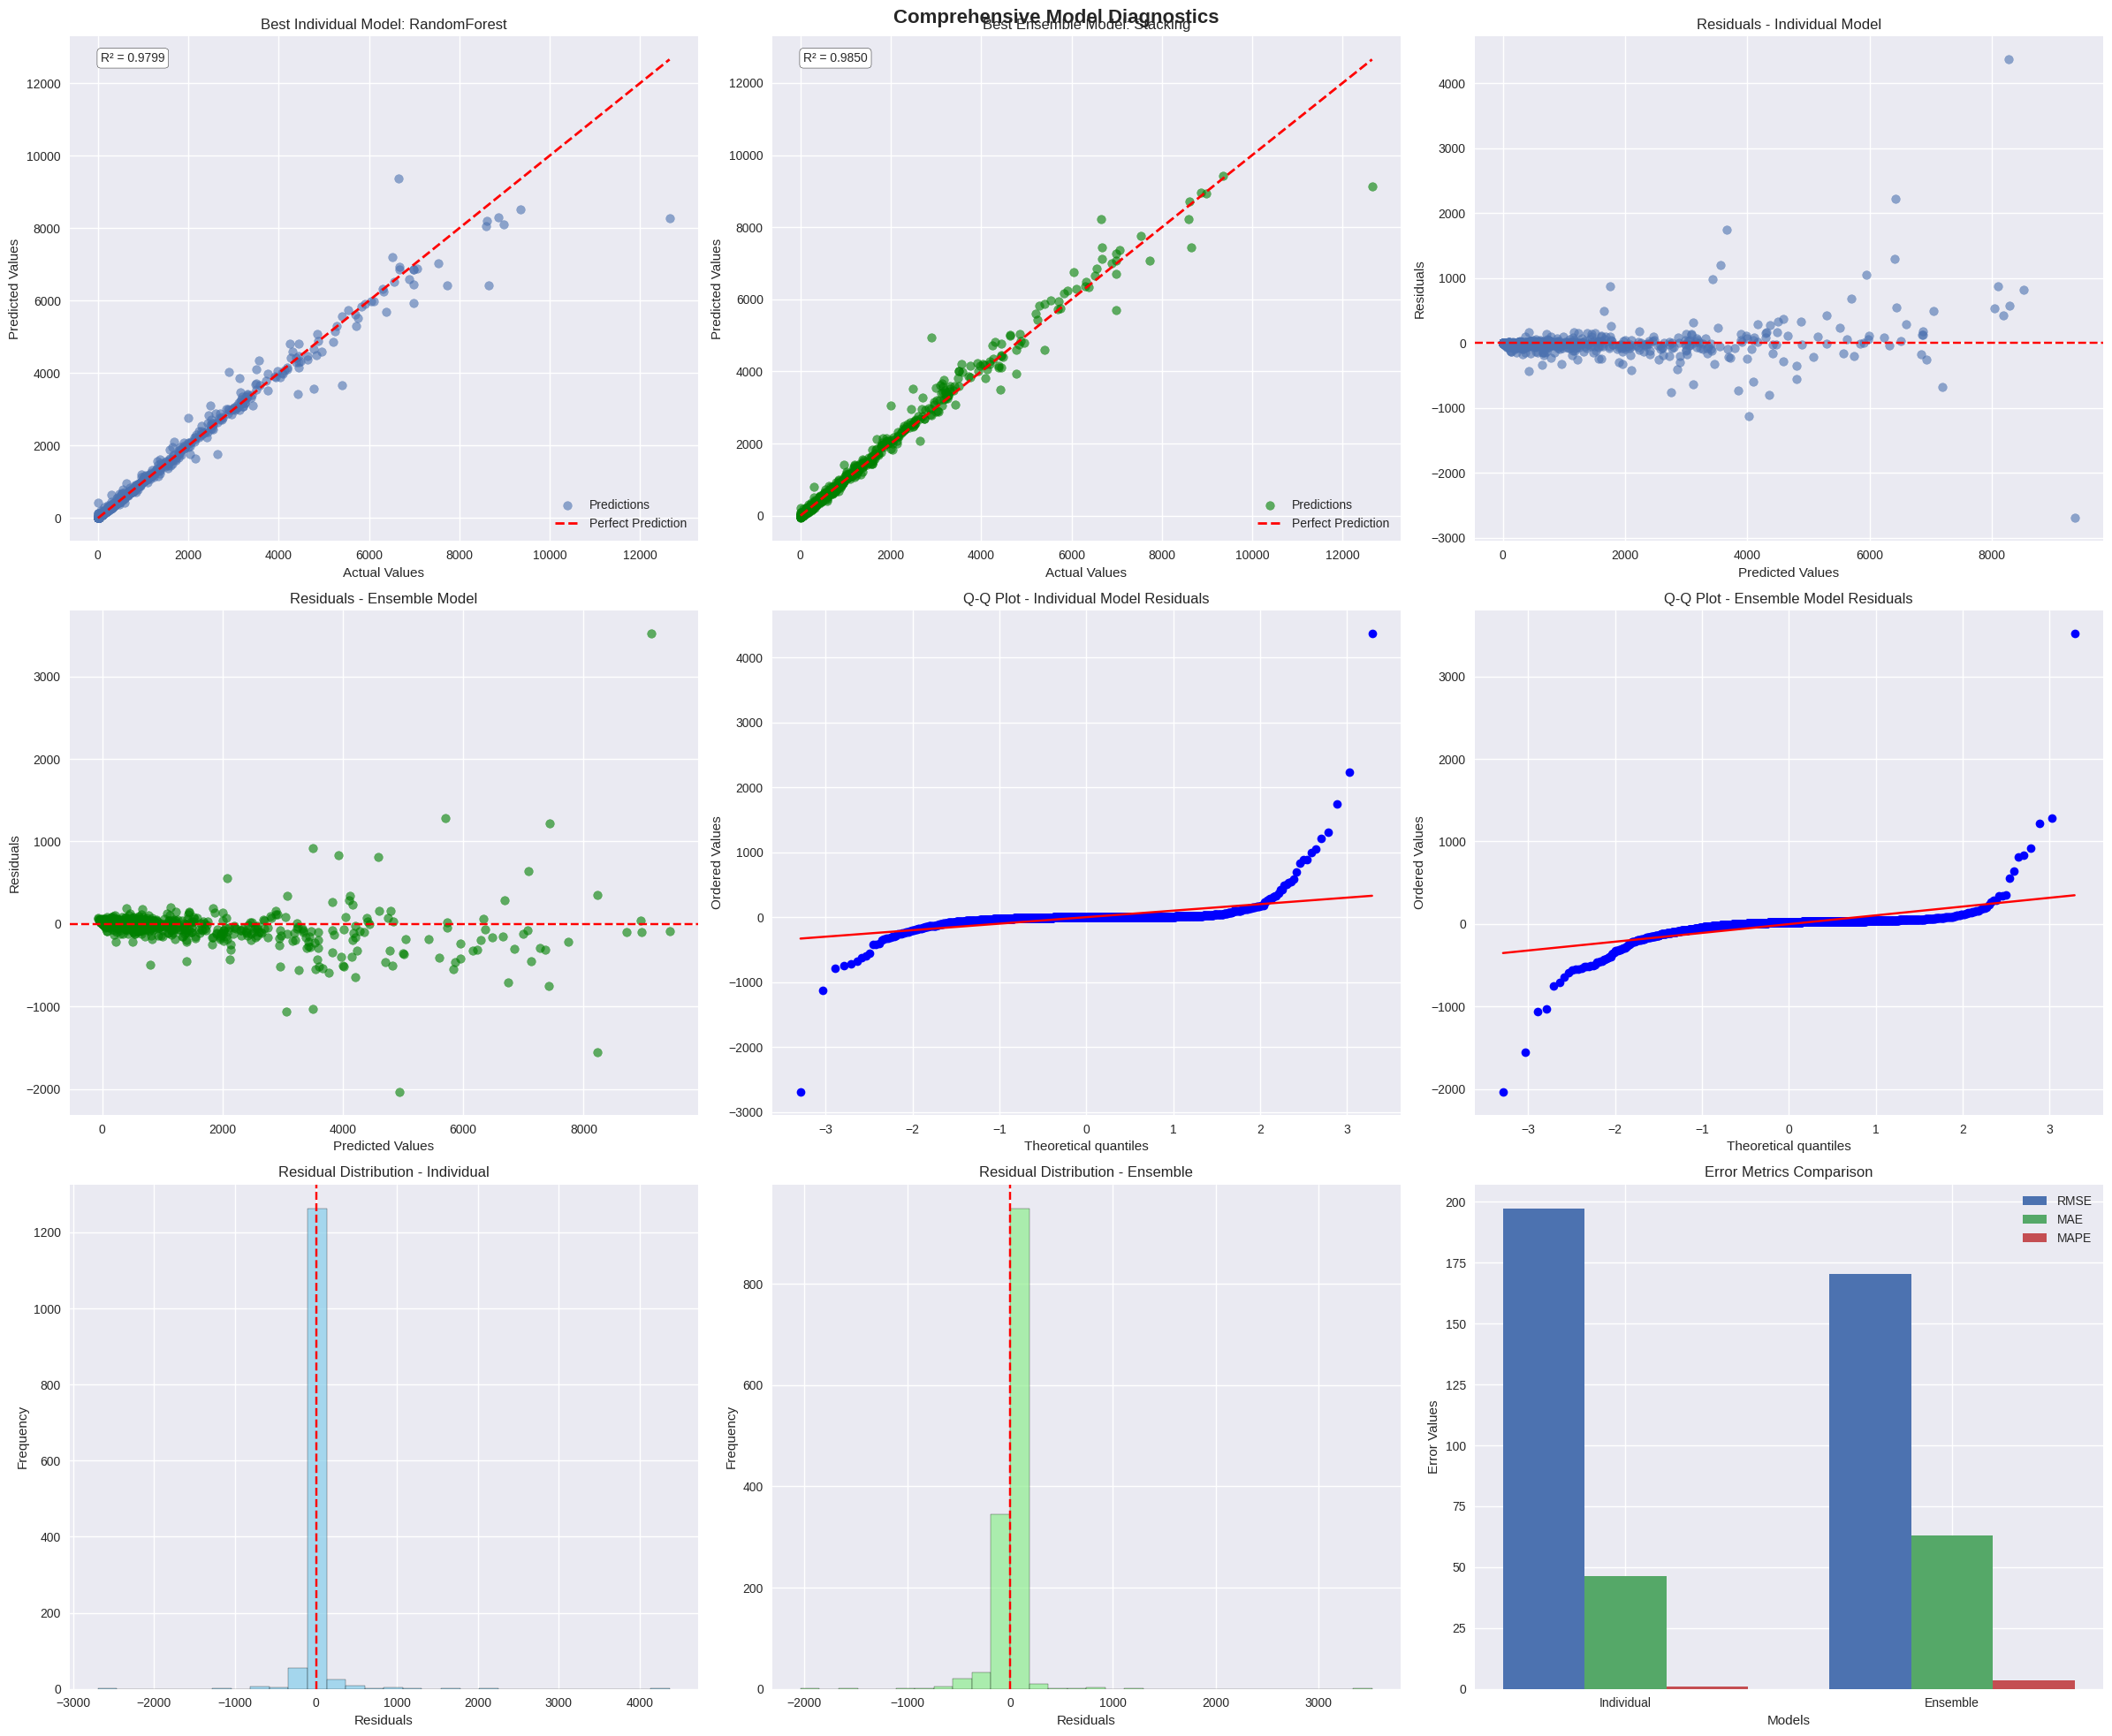


Statistical Diagnostic Tests:
Residual Normality Tests (Jarque-Bera):
Individual Model: Statistic = 2793378.3540, p-value = 0.000000
Ensemble Model: Statistic = 1476441.0907, p-value = 0.000000

Durbin-Watson Test (Autocorrelation):
Individual Model: 2.0097
Ensemble Model: 1.9833
(Values around 2.0 indicate no autocorrelation)

Comprehensive Metrics Comparison:
       Metric  Individual Model  Ensemble Model
          MSE      38921.700106    29023.694280
         RMSE        197.285834      170.363418
          MAE         46.389644       63.057125
           R²          0.979936        0.985039
         MAPE          0.852362        3.427543
Residual_Mean         -1.005151       -2.295922
 Residual_Std        197.283273      170.347947
        PI_95        175.723936      204.219444
        PI_90         89.644026      116.141890


In [14]:
def calculate_advanced_metrics(y_true, y_pred):
    """Calculate comprehensive regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    mape = mean_absolute_percentage_error(y_true, y_pred)

    residuals = y_true - y_pred
    residual_std = np.std(residuals)
    residual_mean = np.mean(residuals)

    pred_interval_95 = np.percentile(np.abs(residuals), 95)
    pred_interval_90 = np.percentile(np.abs(residuals), 90)

    return {
        'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MAPE': mape,
        'Residual_Mean': residual_mean, 'Residual_Std': residual_std,
        'PI_95': pred_interval_95, 'PI_90': pred_interval_90
    }

best_individual_pred = results[best_scaler][best_model_name]['y_pred_test']
best_ensemble_pred = best_ensemble[1]['pred']

individual_metrics = calculate_advanced_metrics(y_test, best_individual_pred)
ensemble_metrics = calculate_advanced_metrics(y_test, best_ensemble_pred)

fig, axes = plt.subplots(3, 3, figsize=(24, 20))
fig.suptitle('Comprehensive Model Diagnostics', fontsize=16, fontweight='bold')

axes[0,0].scatter(y_test, best_individual_pred, alpha=0.6, label='Predictions')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0,0].set_xlabel('Actual Values')
axes[0,0].set_ylabel('Predicted Values')
axes[0,0].set_title(f'Best Individual Model: {best_model_name}')
axes[0,0].legend()
axes[0,0].text(0.05, 0.95, f"R² = {individual_metrics['R²']:.4f}", transform=axes[0,0].transAxes,
               bbox=dict(boxstyle='round', facecolor='white'))

axes[0,1].scatter(y_test, best_ensemble_pred, alpha=0.6, label='Predictions', color='green')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0,1].set_xlabel('Actual Values')
axes[0,1].set_ylabel('Predicted Values')
axes[0,1].set_title(f'Best Ensemble Model: {best_ensemble[0]}')
axes[0,1].legend()
axes[0,1].text(0.05, 0.95, f"R² = {ensemble_metrics['R²']:.4f}", transform=axes[0,1].transAxes,
               bbox=dict(boxstyle='round', facecolor='white'))

individual_residuals = y_test - best_individual_pred
ensemble_residuals = y_test - best_ensemble_pred

axes[0,2].scatter(best_individual_pred, individual_residuals, alpha=0.6)
axes[0,2].axhline(y=0, color='r', linestyle='--')
axes[0,2].set_xlabel('Predicted Values')
axes[0,2].set_ylabel('Residuals')
axes[0,2].set_title('Residuals - Individual Model')

axes[1,0].scatter(best_ensemble_pred, ensemble_residuals, alpha=0.6, color='green')
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Predicted Values')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Residuals - Ensemble Model')

stats.probplot(individual_residuals, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot - Individual Model Residuals')

stats.probplot(ensemble_residuals, dist="norm", plot=axes[1,2])
axes[1,2].set_title('Q-Q Plot - Ensemble Model Residuals')

axes[2,0].hist(individual_residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[2,0].set_xlabel('Residuals')
axes[2,0].set_ylabel('Frequency')
axes[2,0].set_title('Residual Distribution - Individual')
axes[2,0].axvline(x=0, color='r', linestyle='--')

axes[2,1].hist(ensemble_residuals, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[2,1].set_xlabel('Residuals')
axes[2,1].set_ylabel('Frequency')
axes[2,1].set_title('Residual Distribution - Ensemble')
axes[2,1].axvline(x=0, color='r', linestyle='--')

error_comparison = pd.DataFrame({
    'Model': ['Individual', 'Ensemble'],
    'RMSE': [individual_metrics['RMSE'], ensemble_metrics['RMSE']],
    'MAE': [individual_metrics['MAE'], ensemble_metrics['MAE']],
    'MAPE': [individual_metrics['MAPE'], ensemble_metrics['MAPE']]
})

x_pos = np.arange(len(error_comparison))
width = 0.25

axes[2,2].bar(x_pos - width, error_comparison['RMSE'], width, label='RMSE')
axes[2,2].bar(x_pos, error_comparison['MAE'], width, label='MAE')
axes[2,2].bar(x_pos + width, error_comparison['MAPE'], width, label='MAPE')
axes[2,2].set_xlabel('Models')
axes[2,2].set_ylabel('Error Values')
axes[2,2].set_title('Error Metrics Comparison')
axes[2,2].set_xticks(x_pos)
axes[2,2].set_xticklabels(error_comparison['Model'])
axes[2,2].legend()

plt.tight_layout()
plt.show()

print("\nStatistical Diagnostic Tests:")
print("="*50)

individual_jb_stat, individual_jb_p = jarque_bera(individual_residuals)
ensemble_jb_stat, ensemble_jb_p = jarque_bera(ensemble_residuals)

print("Residual Normality Tests (Jarque-Bera):")
print(f"Individual Model: Statistic = {individual_jb_stat:.4f}, p-value = {individual_jb_p:.6f}")
print(f"Ensemble Model: Statistic = {ensemble_jb_stat:.4f}, p-value = {ensemble_jb_p:.6f}")

dw_individual = durbin_watson(individual_residuals)
dw_ensemble = durbin_watson(ensemble_residuals)

print(f"\nDurbin-Watson Test (Autocorrelation):")
print(f"Individual Model: {dw_individual:.4f}")
print(f"Ensemble Model: {dw_ensemble:.4f}")
print("(Values around 2.0 indicate no autocorrelation)")

print(f"\nComprehensive Metrics Comparison:")
print("="*50)
metrics_df = pd.DataFrame({
    'Metric': list(individual_metrics.keys()),
    'Individual Model': list(individual_metrics.values()),
    'Ensemble Model': list(ensemble_metrics.values())
})
print(metrics_df.to_string(index=False, float_format='%.6f'))

# Cross-Validation Setup and Imports

In [15]:
from sklearn.model_selection import validation_curve, learning_curve, KFold
from sklearn.metrics import make_scorer
from sklearn.base import clone

r2_scorer = make_scorer(r2_score)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_strategies = {
    'KFold_5': KFold(n_splits=5, shuffle=True, random_state=42),
    'KFold_10': KFold(n_splits=10, shuffle=True, random_state=42)
}

cv_results = {}

print("Performing cross-validation analysis...")

models_to_analyze = {
    'Best_Individual': results[best_scaler][best_model_name]['model'],
    'Best_Ensemble': best_ensemble[1]['model'] if 'model' in best_ensemble[1] else voting_regressor
}

best_scaler_data = scaled_data.get(best_scaler)

if best_scaler_data is None:
    print(f"Error: Scaled data for scaler '{best_scaler}' not found.")
else:
    print(f"Using scaler: {best_scaler}")
    print(f"Models to analyze: {list(models_to_analyze.keys())}")

if best_scaler_data is not None:
    for model_name, model in models_to_analyze.items():
        print(f"\nAnalyzing {model_name}...")
        cv_results[model_name] = {}

        for cv_name, cv_strategy in cv_strategies.items():
            print(f"  Running {cv_name} cross-validation...")

            r2_scores = cross_val_score(model, best_scaler_data['X_train'], y_train,
                                       cv=cv_strategy, scoring=r2_scorer, n_jobs=-1)
            mse_scores = cross_val_score(model, best_scaler_data['X_train'], y_train,
                                        cv=cv_strategy, scoring=mse_scorer, n_jobs=-1)
            mse_scores = -mse_scores

            cv_results[model_name][cv_name] = {
                'r2_scores': r2_scores,
                'mse_scores': mse_scores,
                'r2_mean': r2_scores.mean(),
                'r2_std': r2_scores.std(),
                'mse_mean': mse_scores.mean(),
                'mse_std': mse_scores.std()
            }

            print(f"    R² Score: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
            print(f"    MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")

    print("\nCross-validation scoring completed!")

if best_scaler_data is not None:
    train_sizes = np.linspace(0.1, 1.0, 10)
    learning_curve_results = {}

    for model_name, model in models_to_analyze.items():
        print(f"Computing learning curves for {model_name}...")

        train_sizes_abs, train_scores, val_scores = learning_curve(
            model, best_scaler_data['X_train'], y_train,
            train_sizes=train_sizes, cv=5, scoring=r2_scorer,
            n_jobs=-1, random_state=42
        )

        learning_curve_results[model_name] = {
            'train_sizes': train_sizes_abs,
            'train_scores_mean': train_scores.mean(axis=1),
            'train_scores_std': train_scores.std(axis=1),
            'val_scores_mean': val_scores.mean(axis=1),
            'val_scores_std': val_scores.std(axis=1)
        }

        print(f"  Learning curve computed with {len(train_sizes_abs)} data points")
        print(f"  Final validation R²: {val_scores.mean(axis=1)[-1]:.4f}")

    print("Learning curves analysis completed!")

Performing cross-validation analysis...
Using scaler: standard
Models to analyze: ['Best_Individual', 'Best_Ensemble']

Analyzing Best_Individual...
  Running KFold_5 cross-validation...
    R² Score: 0.9368 ± 0.0415
    MSE: 142028.6837 ± 102917.1123
  Running KFold_10 cross-validation...
    R² Score: 0.9502 ± 0.0509
    MSE: 129443.4845 ± 164209.1834

Analyzing Best_Ensemble...
  Running KFold_5 cross-validation...
    R² Score: 0.9447 ± 0.0385
    MSE: 124700.8329 ± 95077.3955
  Running KFold_10 cross-validation...
    R² Score: 0.9558 ± 0.0519
    MSE: 116479.4331 ± 165292.8841

Cross-validation scoring completed!
Computing learning curves for Best_Individual...
  Learning curve computed with 10 data points
  Final validation R²: 0.9297
Computing learning curves for Best_Ensemble...
  Learning curve computed with 10 data points
  Final validation R²: 0.9401
Learning curves analysis completed!


# Validation Curves for Hyperparameters

Computing validation curves for hyperparameter analysis...
  Validation curve computed for n_estimators: [10, 50, 100, 200, 300, 500]
  Best n_estimators: 10
  Best validation R²: 0.9553
Validation curves analysis completed!
Cross-validation boxplot created
Learning curves plots created
Validation curves and stability plots created
Analyzing performance over different training data sizes...
  Analyzing Best_Individual...
    0.3 of data: R² = 0.9541
    0.5 of data: R² = 0.9705
    0.7 of data: R² = 0.9678
    0.9 of data: R² = 0.9770
    1.0 of data: R² = 0.9799
  Analyzing Best_Ensemble...
    0.3 of data: R² = 0.9586
    0.5 of data: R² = 0.9797
    0.7 of data: R² = 0.9742
    0.9 of data: R² = 0.9882
    1.0 of data: R² = 0.9845
Subset performance analysis completed!


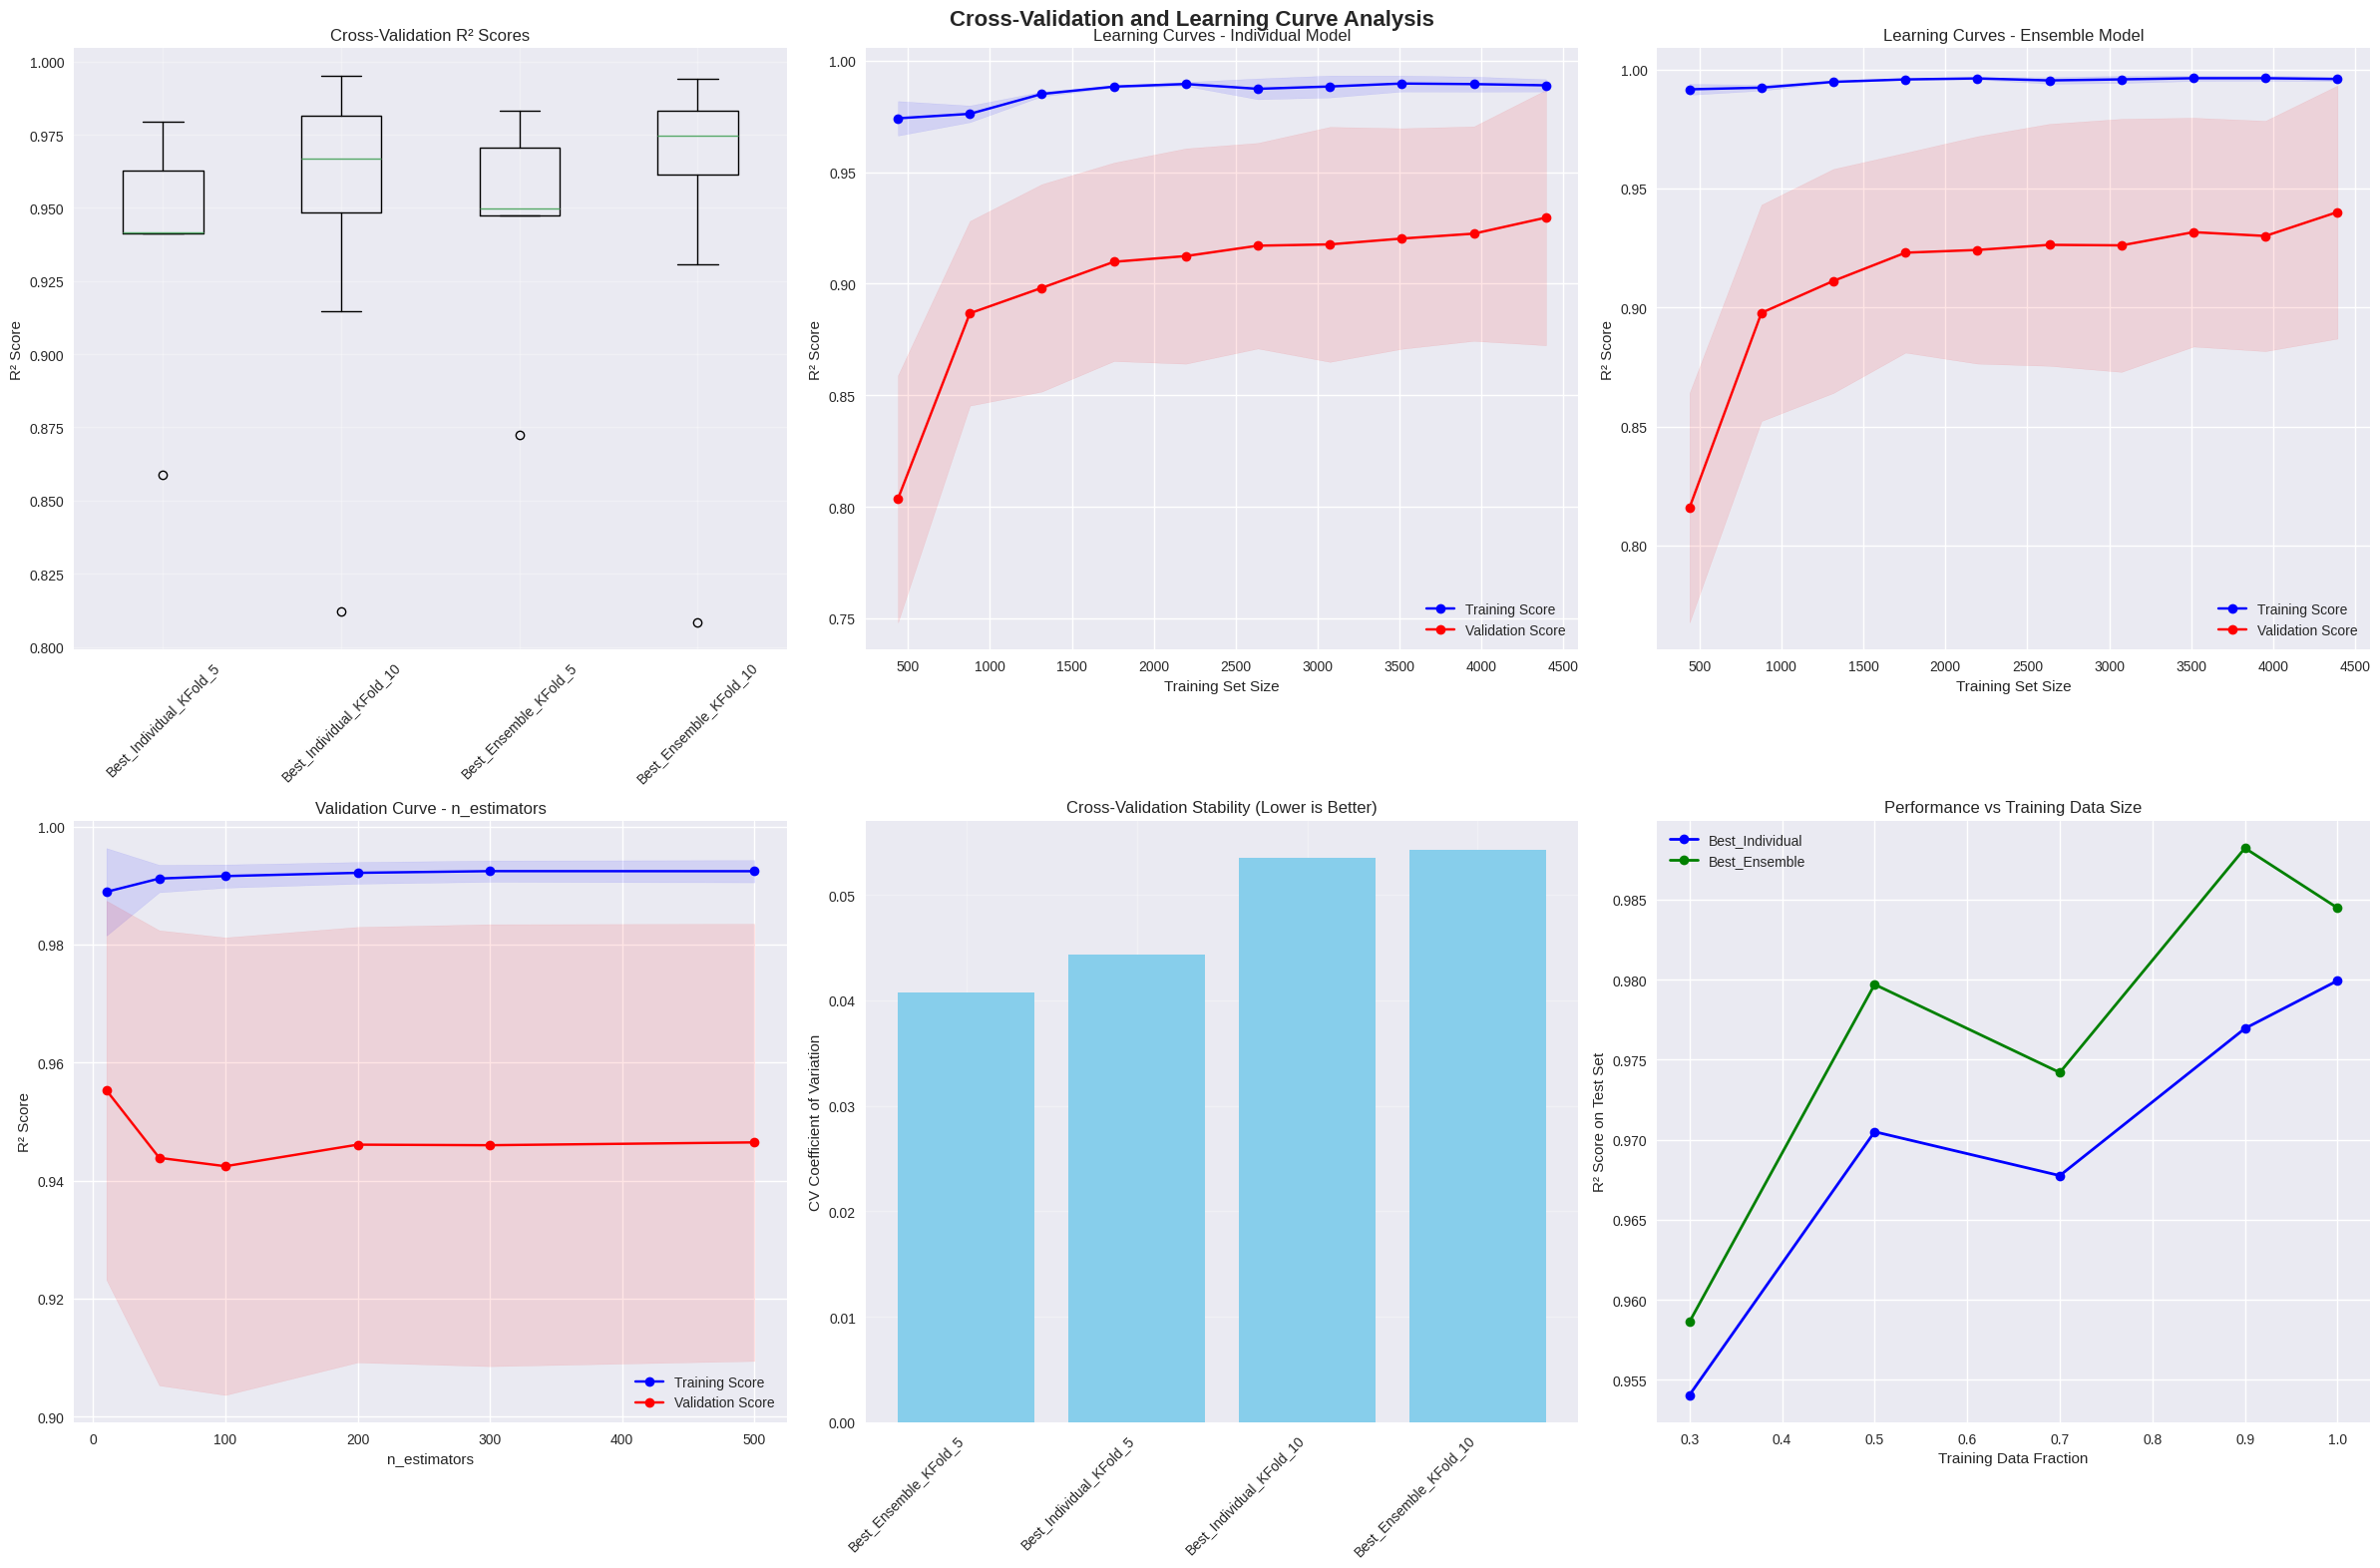

All visualizations completed and displayed!


In [16]:
validation_curve_results = {}

if best_scaler_data is not None:
    if 'RandomForest' in best_model_name:
        print("Computing validation curves for hyperparameter analysis...")

        param_range = [10, 50, 100, 200, 300, 500]
        train_scores, val_scores = validation_curve(
            RandomForestRegressor(random_state=42), best_scaler_data['X_train'], y_train,
            param_name='n_estimators', param_range=param_range,
            cv=5, scoring=r2_scorer, n_jobs=-1
        )

        validation_curve_results['n_estimators'] = {
            'param_range': param_range,
            'train_scores_mean': train_scores.mean(axis=1),
            'train_scores_std': train_scores.std(axis=1),
            'val_scores_mean': val_scores.mean(axis=1),
            'val_scores_std': val_scores.std(axis=1)
        }

        print(f"  Validation curve computed for n_estimators: {param_range}")
        best_param_idx = np.argmax(val_scores.mean(axis=1))
        print(f"  Best n_estimators: {param_range[best_param_idx]}")
        print(f"  Best validation R²: {val_scores.mean(axis=1)[best_param_idx]:.4f}")

    else:
        print(f"Validation curves not implemented for {best_model_name}")

    print("Validation curves analysis completed!")

if best_scaler_data is not None:
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    fig.suptitle('Cross-Validation and Learning Curve Analysis', fontsize=16, fontweight='bold')

    cv_comparison_data = []
    cv_labels = []
    for model_name in cv_results.keys():
        for cv_name in cv_results[model_name].keys():
            cv_comparison_data.append(cv_results[model_name][cv_name]['r2_scores'])
            cv_labels.append(f"{model_name}_{cv_name}")

    axes[0,0].boxplot(cv_comparison_data, labels=cv_labels)
    axes[0,0].set_title('Cross-Validation R² Scores')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)

    print("Cross-validation boxplot created")

if best_scaler_data is not None and 'fig' in locals():
    model_name = 'Best_Individual'
    if model_name in learning_curve_results:
        lc_data = learning_curve_results[model_name]
        axes[0,1].plot(lc_data['train_sizes'], lc_data['train_scores_mean'], 'o-',
                      label='Training Score', color='blue')
        axes[0,1].fill_between(lc_data['train_sizes'],
                              lc_data['train_scores_mean'] - lc_data['train_scores_std'],
                              lc_data['train_scores_mean'] + lc_data['train_scores_std'],
                              alpha=0.1, color='blue')

        axes[0,1].plot(lc_data['train_sizes'], lc_data['val_scores_mean'], 'o-',
                      label='Validation Score', color='red')
        axes[0,1].fill_between(lc_data['train_sizes'],
                              lc_data['val_scores_mean'] - lc_data['val_scores_std'],
                              lc_data['val_scores_mean'] + lc_data['val_scores_std'],
                              alpha=0.1, color='red')

        axes[0,1].set_xlabel('Training Set Size')
        axes[0,1].set_ylabel('R² Score')
        axes[0,1].set_title('Learning Curves - Individual Model')
        axes[0,1].legend()
        axes[0,1].grid(True)

    model_name = 'Best_Ensemble'
    if model_name in learning_curve_results:
        lc_data = learning_curve_results[model_name]
        axes[0,2].plot(lc_data['train_sizes'], lc_data['train_scores_mean'], 'o-',
                      label='Training Score', color='blue')
        axes[0,2].fill_between(lc_data['train_sizes'],
                              lc_data['train_scores_mean'] - lc_data['train_scores_std'],
                              lc_data['train_scores_mean'] + lc_data['train_scores_std'],
                              alpha=0.1, color='blue')

        axes[0,2].plot(lc_data['train_sizes'], lc_data['val_scores_mean'], 'o-',
                      label='Validation Score', color='red')
        axes[0,2].fill_between(lc_data['train_sizes'],
                              lc_data['val_scores_mean'] - lc_data['val_scores_std'],
                              lc_data['val_scores_mean'] + lc_data['val_scores_std'],
                              alpha=0.1, color='red')

        axes[0,2].set_xlabel('Training Set Size')
        axes[0,2].set_ylabel('R² Score')
        axes[0,2].set_title('Learning Curves - Ensemble Model')
        axes[0,2].legend()
        axes[0,2].grid(True)

    print("Learning curves plots created")

if best_scaler_data is not None and 'fig' in locals():
    if validation_curve_results:
        for param_name, vc_data in validation_curve_results.items():
            axes[1,0].plot(vc_data['param_range'], vc_data['train_scores_mean'], 'o-',
                          label='Training Score', color='blue')
            axes[1,0].fill_between(vc_data['param_range'],
                                  vc_data['train_scores_mean'] - vc_data['train_scores_std'],
                                  vc_data['train_scores_mean'] + vc_data['train_scores_std'],
                                  alpha=0.1, color='blue')

            axes[1,0].plot(vc_data['param_range'], vc_data['val_scores_mean'], 'o-',
                          label='Validation Score', color='red')
            axes[1,0].fill_between(vc_data['param_range'],
                                  vc_data['val_scores_mean'] - vc_data['val_scores_std'],
                                  vc_data['val_scores_mean'] + vc_data['val_scores_std'],
                                  alpha=0.1, color='red')

            axes[1,0].set_xlabel(param_name)
            axes[1,0].set_ylabel('R² Score')
            axes[1,0].set_title(f'Validation Curve - {param_name}')
            axes[1,0].legend()
            axes[1,0].grid(True)
            break
    else:
        axes[1,0].text(0.5, 0.5, 'No validation curves available',
                       ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Validation Curves')

    cv_stability = []
    for model_name in cv_results.keys():
        for cv_name in cv_results[model_name].keys():
            stability = cv_results[model_name][cv_name]['r2_std'] / cv_results[model_name][cv_name]['r2_mean']
            cv_stability.append((f"{model_name}_{cv_name}", stability))

    cv_stability.sort(key=lambda x: x[1])
    stability_names, stability_values = zip(*cv_stability)

    axes[1,1].bar(range(len(stability_values)), stability_values, color='skyblue')
    axes[1,1].set_xticks(range(len(stability_names)))
    axes[1,1].set_xticklabels(stability_names, rotation=45, ha='right')
    axes[1,1].set_ylabel('CV Coefficient of Variation')
    axes[1,1].set_title('Cross-Validation Stability (Lower is Better)')
    axes[1,1].grid(True, alpha=0.3)

    print("Validation curves and stability plots created")

if best_scaler_data is not None:
    subset_sizes = [0.3, 0.5, 0.7, 0.9, 1.0]
    subset_performance = {}

    print("Analyzing performance over different training data sizes...")

    for model_name, model in models_to_analyze.items():
        print(f"  Analyzing {model_name}...")
        subset_r2_scores = []
        subset_mse_scores = []

        for subset_size in subset_sizes:
            n_samples = int(len(best_scaler_data['X_train']) * subset_size)
            X_subset = best_scaler_data['X_train'][:n_samples]
            y_subset = y_train[:n_samples]

            model_copy = clone(model)
            model_copy.fit(X_subset, y_subset)
            y_pred_subset = model_copy.predict(best_scaler_data['X_test'])

            subset_r2 = r2_score(y_test, y_pred_subset)
            subset_mse = mean_squared_error(y_test, y_pred_subset)

            subset_r2_scores.append(subset_r2)
            subset_mse_scores.append(subset_mse)

            print(f"    {subset_size:.1f} of data: R² = {subset_r2:.4f}")

        subset_performance[model_name] = {
            'r2_scores': subset_r2_scores,
            'mse_scores': subset_mse_scores
        }

    print("Subset performance analysis completed!")

if best_scaler_data is not None and 'fig' in locals():
    colors = ['blue', 'green', 'red', 'orange']
    for i, (model_name, perf_data) in enumerate(subset_performance.items()):
        color = colors[i % len(colors)]
        axes[1,2].plot(subset_sizes, perf_data['r2_scores'], 'o-',
                      label=model_name, color=color, linewidth=2)

    axes[1,2].set_xlabel('Training Data Fraction')
    axes[1,2].set_ylabel('R² Score on Test Set')
    axes[1,2].set_title('Performance vs Training Data Size')
    axes[1,2].legend()
    axes[1,2].grid(True)

    plt.tight_layout()
    plt.show()

    print("All visualizations completed and displayed!")

# Cross-Validation Results and Statistical Significance Testing

In [17]:
if best_scaler_data is not None:
    print("Detailed Cross-Validation Results:")
    print("="*80)
    for model_name in cv_results.keys():
        print(f"\n{model_name}:")
        print("-" * 40)
        for cv_name, cv_data in cv_results[model_name].items():
            print(f"{cv_name}:")
            print(f"  R² Score: {cv_data['r2_mean']:.4f} ± {cv_data['r2_std']:.4f}")
            print(f"  MSE: {cv_data['mse_mean']:.4f} ± {cv_data['mse_std']:.4f}")
            print(f"  Individual R² scores: {[f'{score:.4f}' for score in cv_data['r2_scores']]}")
            print(f"  Score range: [{cv_data['r2_scores'].min():.4f}, {cv_data['r2_scores'].max():.4f}]")

            cv_coefficient = cv_data['r2_std'] / cv_data['r2_mean'] if cv_data['r2_mean'] != 0 else float('inf')
            print(f"  Coefficient of Variation: {cv_coefficient:.4f}")

            if cv_coefficient < 0.1:
                stability = "Very Stable"
            elif cv_coefficient < 0.2:
                stability = "Stable"
            elif cv_coefficient < 0.3:
                stability = "Moderately Stable"
            else:
                stability = "Unstable"
            print(f"  Stability: {stability}")

    print(f"\nCross-validation analysis summary completed!")

if best_scaler_data is not None:
    from scipy.stats import ttest_rel, wilcoxon

    print(f"Statistical Significance Testing:")
    print("="*50)

    if len(models_to_analyze) >= 2:
        model_names = list(models_to_analyze.keys())
        model1_scores = cv_results[model_names[0]]['KFold_5']['r2_scores']
        model2_scores = cv_results[model_names[1]]['KFold_5']['r2_scores']

        print(f"Comparing {model_names[0]} vs {model_names[1]}:")
        print(f"Model 1 mean R²: {model1_scores.mean():.4f}")
        print(f"Model 2 mean R²: {model2_scores.mean():.4f}")
        print(f"Difference: {model2_scores.mean() - model1_scores.mean():.4f}")

        try:
            t_stat, t_p_value = ttest_rel(model1_scores, model2_scores)
            print(f"\nPaired t-test:")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {t_p_value:.4f}")
            print(f"  Significant difference (α=0.05): {'Yes' if t_p_value < 0.05 else 'No'}")

            pooled_std = np.sqrt(((len(model1_scores)-1)*model1_scores.std()**2 +
                                (len(model2_scores)-1)*model2_scores.std()**2) /
                               (len(model1_scores) + len(model2_scores) - 2))
            cohens_d = (model2_scores.mean() - model1_scores.mean()) / pooled_std
            print(f"  Cohen's d (effect size): {cohens_d:.4f}")

            if abs(cohens_d) < 0.2:
                effect_size = "Small"
            elif abs(cohens_d) < 0.8:
                effect_size = "Medium"
            else:
                effect_size = "Large"
            print(f"  Effect size interpretation: {effect_size}")

        except Exception as e:
            print(f"  t-test failed: {e}")

        try:
            w_stat, w_p_value = wilcoxon(model1_scores, model2_scores)
            print(f"\nWilcoxon signed-rank test (non-parametric):")
            print(f"  W-statistic: {w_stat:.4f}")
            print(f"  p-value: {w_p_value:.4f}")
            print(f"  Significant difference (α=0.05): {'Yes' if w_p_value < 0.05 else 'No'}")
        except Exception as e:
            print(f"  Wilcoxon test failed: {e}")

    else:
        print("Only one model available - cannot perform significance testing")

    print("\nStatistical testing completed!")

Detailed Cross-Validation Results:

Best_Individual:
----------------------------------------
KFold_5:
  R² Score: 0.9368 ± 0.0415
  MSE: 142028.6837 ± 102917.1123
  Individual R² scores: ['0.9628', '0.9415', '0.8588', '0.9795', '0.9414']
  Score range: [0.8588, 0.9795]
  Coefficient of Variation: 0.0443
  Stability: Very Stable
KFold_10:
  R² Score: 0.9502 ± 0.0509
  MSE: 129443.4845 ± 164209.1834
  Individual R² scores: ['0.9835', '0.9572', '0.9669', '0.9454', '0.9757', '0.8122', '0.9665', '0.9952', '0.9844', '0.9147']
  Score range: [0.8122, 0.9952]
  Coefficient of Variation: 0.0535
  Stability: Very Stable

Best_Ensemble:
----------------------------------------
KFold_5:
  R² Score: 0.9447 ± 0.0385
  MSE: 124700.8329 ± 95077.3955
  Individual R² scores: ['0.9705', '0.9497', '0.8724', '0.9833', '0.9475']
  Score range: [0.8724, 0.9833]
  Coefficient of Variation: 0.0408
  Stability: Very Stable
KFold_10:
  R² Score: 0.9558 ± 0.0519
  MSE: 116479.4331 ± 165292.8841
  Individual R² s